# Table Of Contents:

- [Explorative Data Analysis and Data Preprocessing](#first-bullet)
- [Machine Learning Overall](#second-bullet)
- [Detailed Random Forest](#third-bullet)
- [Detailed K-Nearest Neighbors](#fourth-bullet)
- [Detailed Logistic Regression](#fifth-bullet)
- [Learning Curve](#sixth-bullet)
- [Neural Network](#seventh-bullet)
- [Conclusion](#eight-bullet)

(getting to the section via the link will take its time)

## Explorative Data Analysis and Data Preprocessing <a class="anchor" id="first-bullet"></a>


We import some useful library.

In [1]:
#linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from IPython.display import display
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('dataset.csv')

We start looking at the data displaying the the first 10 entries and then we check whether our dataset present null entries.

In [3]:
df.head(10)

,ID,var1,var2,var3,var4,var5,var6,var7,var8,outcome
0,1,337.0,118.0,high,4.5,4.5,9.65,B,NaN,Z
1,2,324.0,107.0,high,4.0,4.5,8.87,B,NaN,Y
2,3,316.0,104.0,medium,3.0,3.5,8.00,B,NaN,Y
3,4,322.0,110.0,medium,3.5,2.5,8.67,B,NaN,Y
4,5,314.0,103.0,low,2.0,3.0,8.21,A,NaN,Y
5,6,330.0,115.0,highest,4.5,3.0,9.34,B,NaN,Z
6,7,321.0,109.0,medium,3.0,4.0,8.20,B,NaN,Y
7,8,308.0,101.0,low,3.0,4.0,7.90,A,NaN,Y
8,9,302.0,102.0,lowest,2.0,1.5,8.00,A,NaN,X
9,10,323.0,108.0,medium,3.5,3.0,8.60,A,NaN,X


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       500 non-null    int64  
 1   var1     499 non-null    float64
 2   var2     498 non-null    float64
 3   var3     500 non-null    object 
 4   var4     500 non-null    float64
 5   var5     500 non-null    float64
 6   var6     500 non-null    float64
 7   var7     497 non-null    object 
 8   var8     8 non-null      float64
 9   outcome  490 non-null    object 
dtypes: float64(6), int64(1), object(3)
memory usage: 39.2+ KB


As we have seen var8 it has too many missing value and most probably we are going to not considering it when performing our analysis. We will drop also the ID column. 
It is important to notice that not all the data are labelled. We have 10 missing entries in the target column $outcome$.

We now address the missing values starting with the cathegorical variable 7. The first step is to control how many different values we have.

In [5]:
df['var7'].unique()

array(['B', 'A', nan], dtype=object)

So we treat var 7 as a boolean variable. Since we need to add only 3 entries out of 500 we will fill the missing values with the mode. In the case it we needed to sobstitute more entries we will draw them randomly using a Bernoulli distribution with probability $$p_A = total_A/total_{entries}$$.

In [6]:
Fill = df['var7'].mode().iloc[0]
df['var7'] = df['var7'].fillna(Fill)

Next we look at the cathegorical variable var3. We look how many different entries we have. We will see that there is a fault entry.

In [7]:
print(df['var3'].unique())
df['var3'].value_counts()

['high' 'medium' 'low' 'highest' 'lowest' '99']


medium     161
low        126
high       105
highest     73
lowest      34
99           1
Name: var3, dtype: int64

Since is not possible to recognise which kind of value it correspond to the entry $99$ we will drop it. Moreover, the values clearly have an order so that later we can change them easily into numbers (accordingly) without creating any problem.

In [8]:
df = df.drop(df.index[df['var3']=='99'], axis = 0)

Without more insights on the data we are looking it is tricky to decide what to plot. In this case we decide to look a little bit deeper inside the cathegorical variables and how the outcome is distributed.

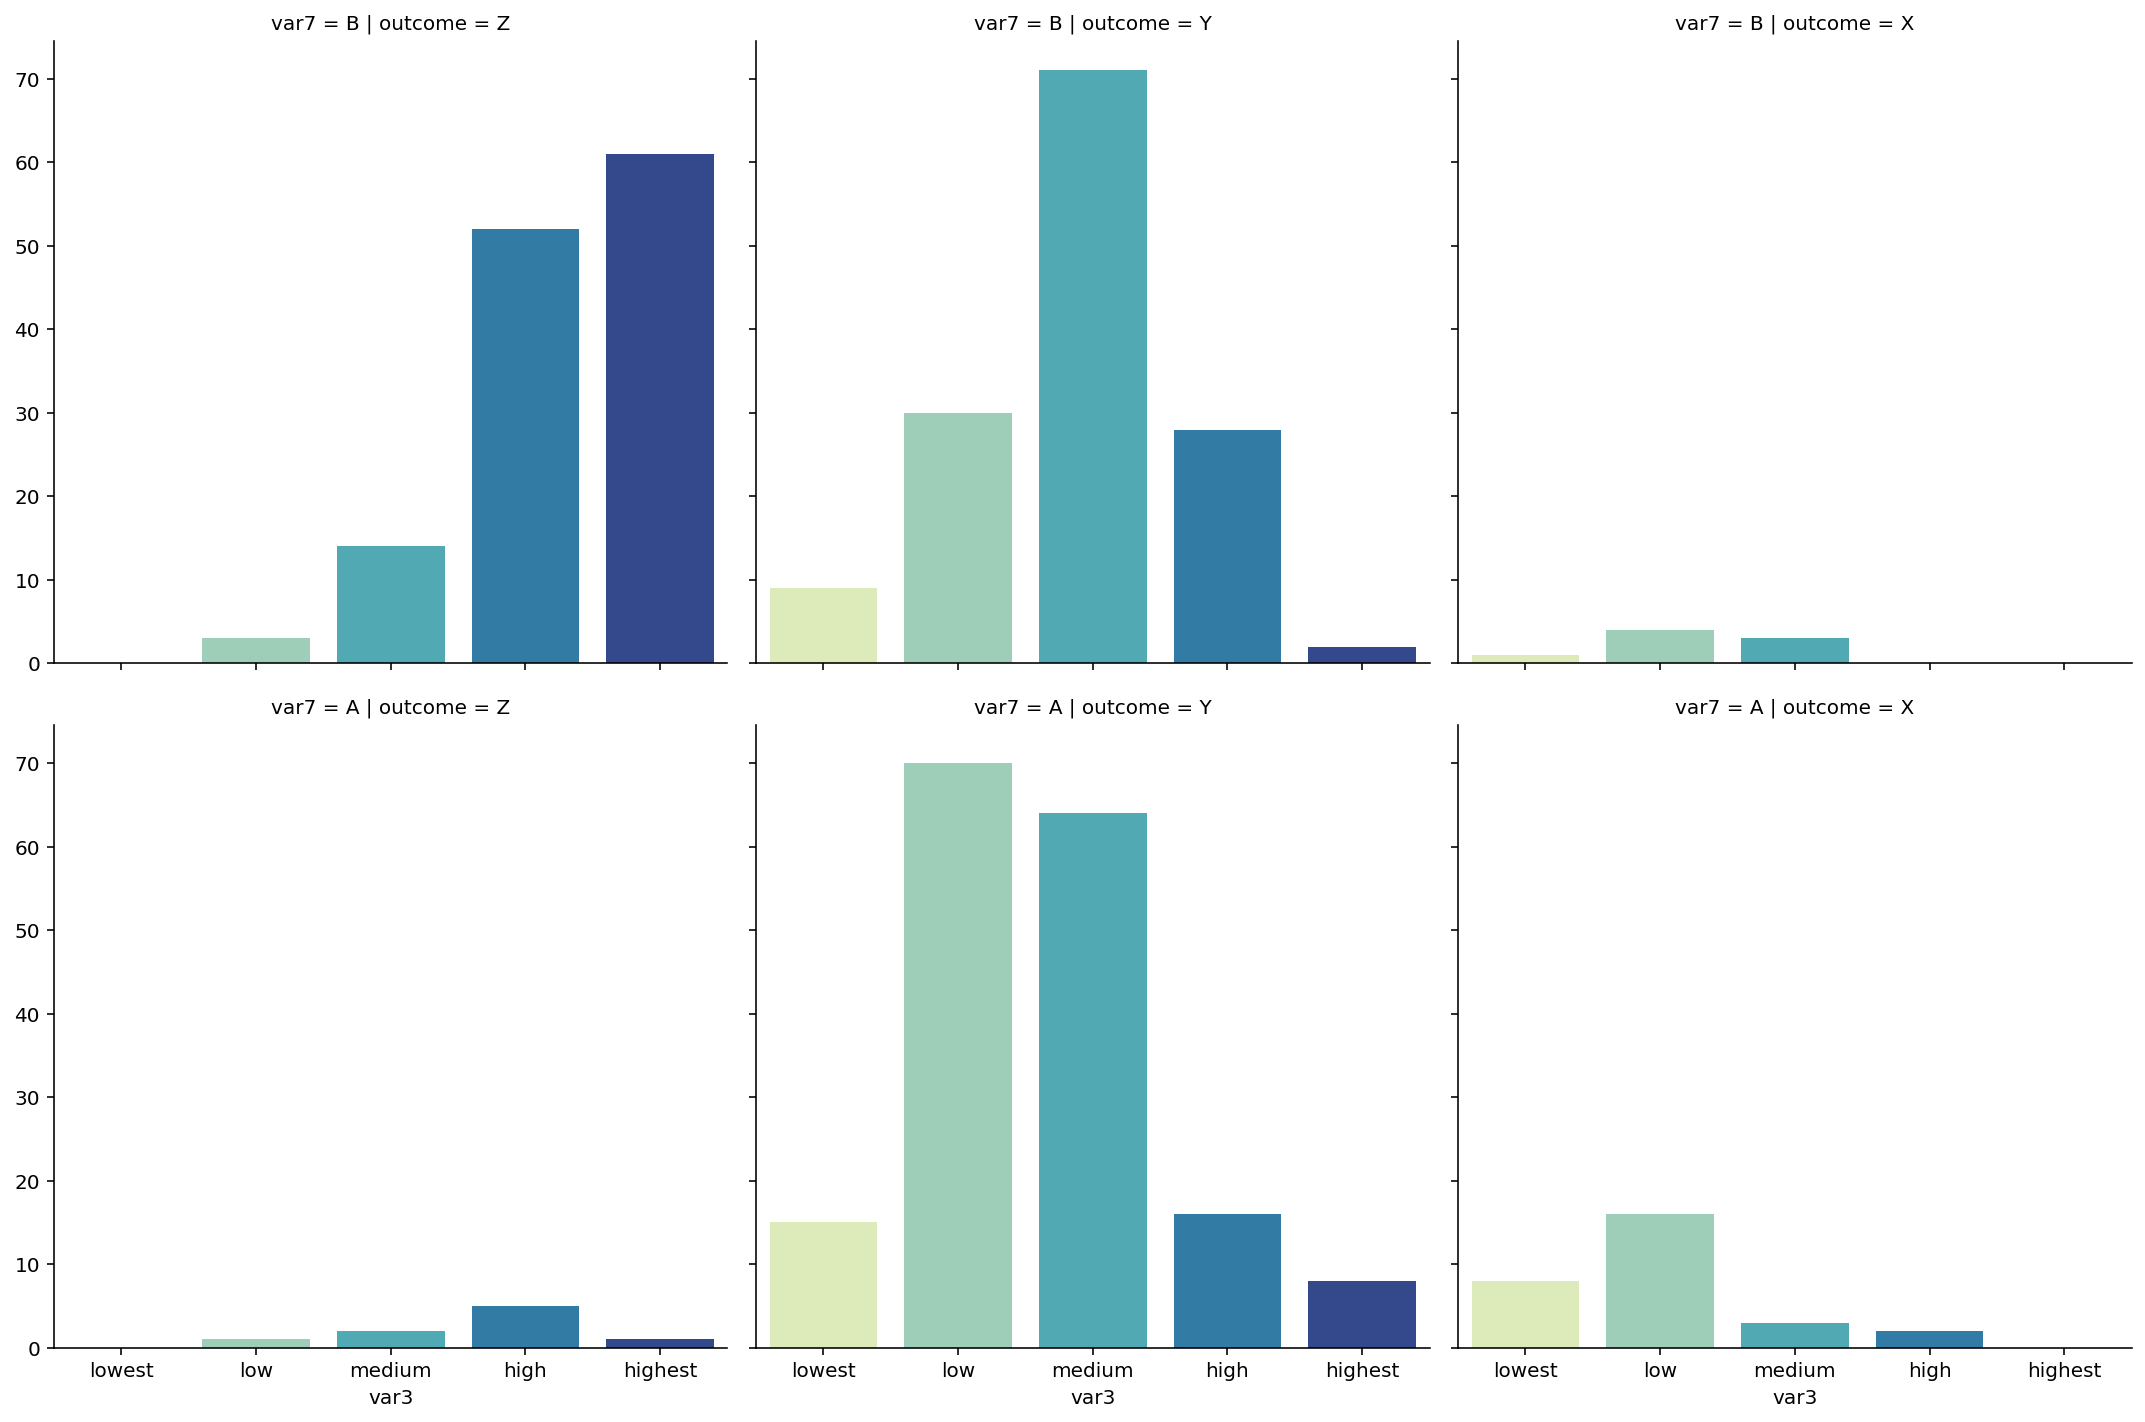

In [9]:
g = sns.FacetGrid(df, col="outcome", row = 'var7',height=5, aspect=1)
g.map(sns.countplot,'var3',order=['lowest','low','medium','high','highest'], palette = 'YlGnBu')

It is actually much more clearer to use the graphic object ambient. Unfortunately, to have the plots rendered correctly in pdf or html it require a package that I cannot access at themoment. However, I re port the code that I used.

Note that neither class A or B have outcome Z classified as lowest and they do note have any outcome X classified as highest. 

Now dealing with cathegorical variables with a lot of several text entries it is possible to generate a Word Cloud for a better impact.

Text(0.5, 1.0, 'Var7 Classes')

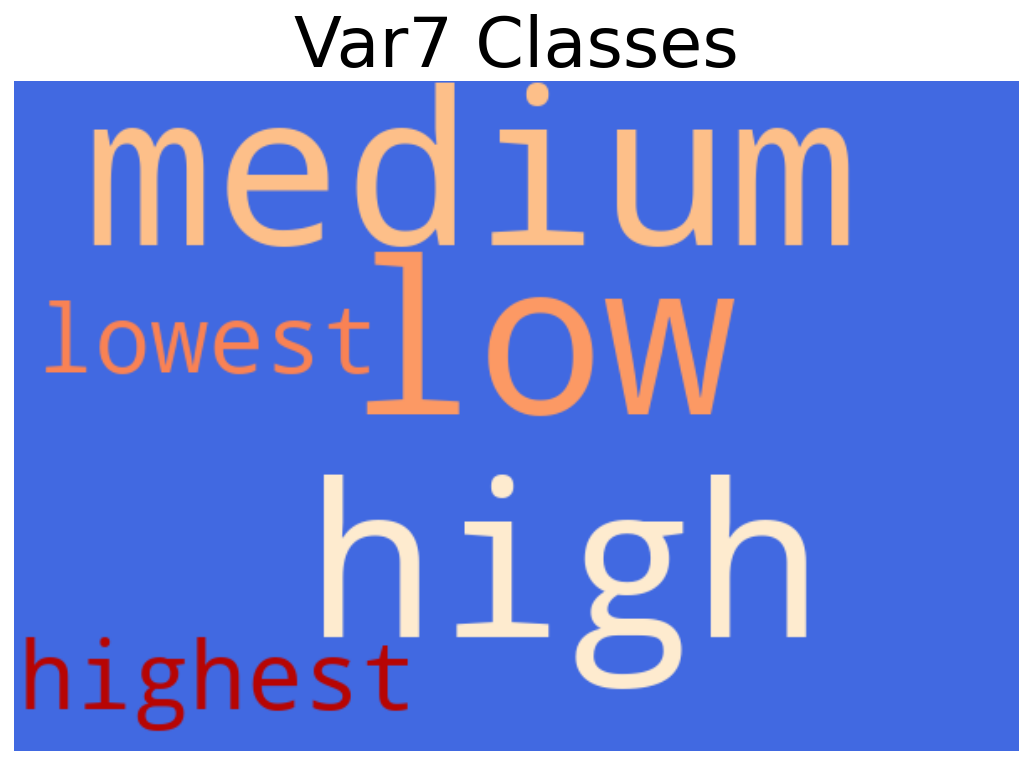

In [10]:
from wordcloud import WordCloud, ImageColorGenerator
text = list(df['var3'].unique().astype(str))
fig, (ax2) = plt.subplots(1,1,figsize=[9, 7])
wordcloud2 = WordCloud(background_color='royalblue',colormap="OrRd_r",
                        width=600,height=400).generate_from_text(" ".join(text))
ax2.imshow(wordcloud2,interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Var7 Classes',fontsize=35)





We continue our explorative data analysis addressing the null values of var1 and var2 it will be enough to substitute the missing value with a random number in the range $[mean_{var_i}-std_{var_i},mean_{var_i}+std_{var_i}]$, where $std_{var_i}$ is the standard deviation of $var_i$ $i=1,2$;

Now, this require a comment because we are performing a data manipulation prior to our division in train set and test set. This is usually not optimal because we are carrying information from one set to another. On the other hand the amount of the data we are "carrying" is not significant in this particular case.

In [11]:
var1_mean = df['var1'].mean()
var1_std = df['var1'].std()
df['var1'] = df['var1'].fillna(np.random.randint(var1_mean-var1_std ,var1_mean+var1_std))
var2_mean = df['var2'].mean()
var2_std = df['var2'].std()
df['var2'] = df['var2'].fillna(np.random.randint(var2_mean-var2_std ,var2_mean+var2_std))

We now look for outliers for the variables 4,5,6.

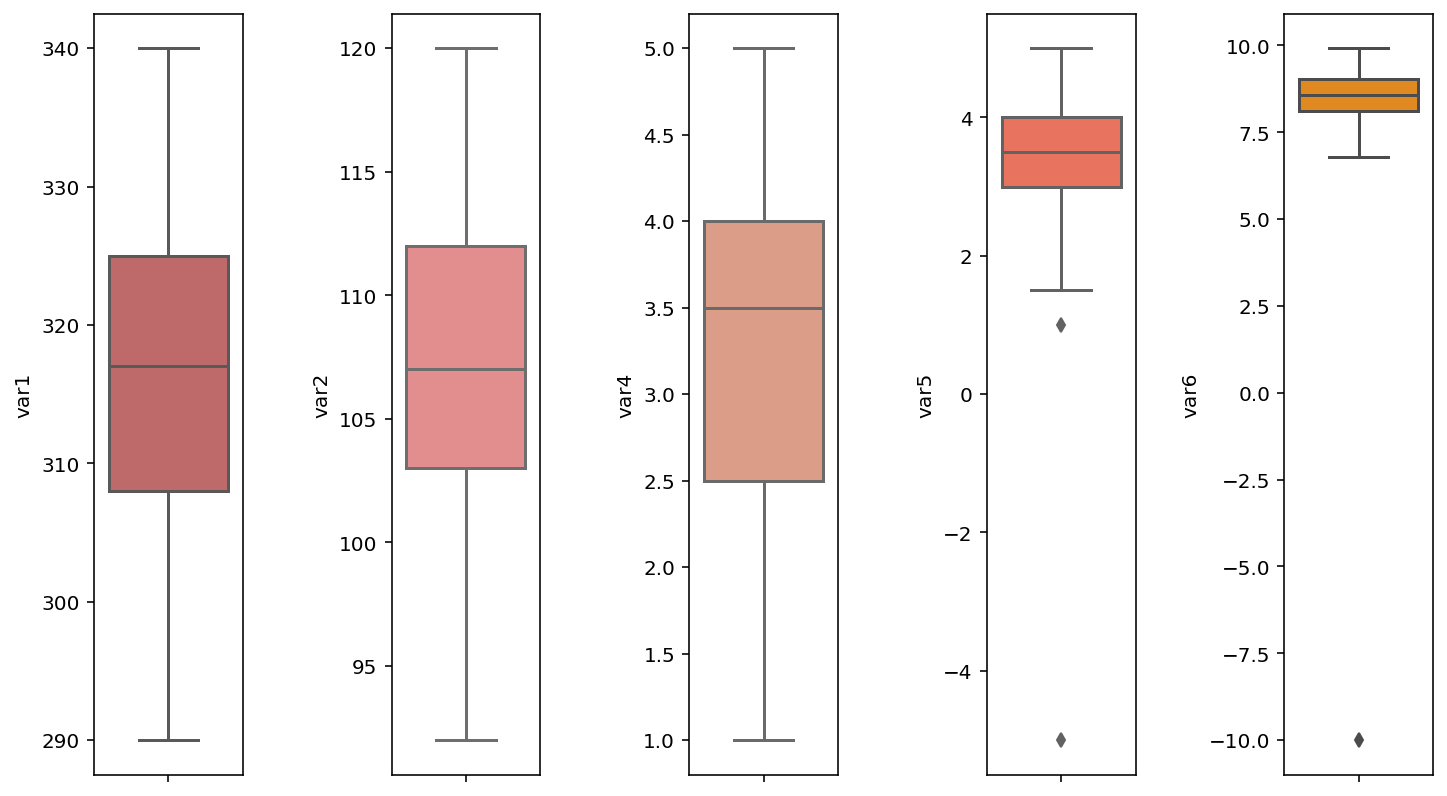

In [12]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=1)
ax = fig.add_subplot(1, 5, 1)
sns.boxplot(y = df['var1'], color = 'indianred' ,ax=ax)
ax = fig.add_subplot(1, 5, 2)
sns.boxplot(y = df['var2'],color = 'lightcoral' ,ax=ax)
ax = fig.add_subplot(1, 5, 3)
sns.boxplot(y = df['var4'],color = 'darksalmon' ,ax=ax)
ax = fig.add_subplot(1, 5, 4)
sns.boxplot(y = df['var5'],color = 'tomato' ,ax=ax)
ax = fig.add_subplot(1, 5, 5)
sns.boxplot(y = df['var6'],color = 'darkorange' ,ax=ax)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

As we see we have three outliers two for var5 and one for var 6. We have eliminated the most extreme two, that are var5 = -5 and var6 = -10. 
It is actually more detailed (and clear) to use the boxplot of the graphic object library. Unfortunately, to render the output in a pdf or html format it is required a package that I have no access at the moment. I include the code just for sake of compliteness.

In [13]:
df = df.drop(df.index[df['var5']==-5], axis = 0) #drop outlier for var5
df = df.drop(df.index[df['var6']==-10], axis = 0) #drop outlier for var6

We try to see if the very few data for var8 can give some insight to be expanded to all the data.

In [14]:
df[df['var8'].isna() == False]

,ID,var1,var2,var3,var4,var5,var6,var7,var8,outcome
25,26,340.0,120.0,highest,4.5,4.5,9.60,B,1.0,Z
75,76,329.0,114.0,low,2.0,4.0,8.56,B,4.0,Y
124,125,301.0,106.0,high,2.5,3.0,8.47,A,7.0,Y
191,192,323.0,110.0,highest,4.0,5.0,8.98,B,8.0,Z
238,239,310.0,104.0,medium,2.0,3.5,8.37,A,1.0,Y
302,303,322.0,105.0,low,3.0,3.0,8.45,B,3.0,Y
390,391,314.0,102.0,low,2.0,2.5,8.24,A,3.0,Y
405,406,302.0,99.0,medium,2.5,3.0,7.45,A,6.0,NaN


Unfortunately there is no evident way to extend them to the whole dataset so we will drop the column var8.

In [15]:
df = df.drop(['ID','var8'], axis = 1)

Now, is the turn to explore the label column $outcome$ and decide what to do with the missing values.

In [16]:
df['outcome'].value_counts()

Y    313
Z    137
X     37
Name: outcome, dtype: int64

In [17]:
#checking the null values
df[df['outcome'].isna()]

,var1,var2,var3,var4,var5,var6,var7,outcome
91,299.0,97.0,medium,5.0,3.5,7.66,A,NaN
103,317.0,104.0,low,4.5,4.0,8.47,A,NaN
139,318.0,109.0,lowest,3.5,3.5,9.12,A,NaN
172,322.0,110.0,high,4.0,5.0,9.13,B,NaN
195,307.0,107.0,low,3.0,3.5,8.52,B,NaN
203,334.0,120.0,highest,4.0,5.0,9.87,B,NaN
398,312.0,103.0,medium,3.5,4.0,8.78,A,NaN
403,330.0,116.0,high,4.0,3.5,9.23,B,NaN
405,302.0,99.0,medium,2.5,3.0,7.45,A,NaN
420,299.0,100.0,medium,2.0,3.0,7.42,A,NaN


As we have already notice not all the features are numerical so we tranform them. 

In [18]:
bool_var7 = {'A':0, 'B':1}
df['var7'] = df['var7'].map(bool_var7)
var3_num = {'lowest':0, 'low':1, 'medium':2, 'high':3, 'highest':4}
df['var3'] = df['var3'].map(var3_num)
print(df['var3'].unique(),df['var7'].unique())

[3 2 1 4 0] [1 0]


So now we can have a better picture of the data and how they are distributed.

In [19]:
df.describe()

,var1,var2,var3,var4,var5,var6,var7
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,316.384306,107.175050,2.110664,3.369215,3.482897,8.573078,0.563380
std,11.289947,6.049822,1.143806,0.990885,0.925234,0.604671,0.496466
min,290.000000,92.000000,0.000000,1.000000,1.000000,6.800000,0.000000
25%,308.000000,103.000000,1.000000,2.500000,3.000000,8.120000,0.000000
50%,316.000000,107.000000,2.000000,3.500000,3.500000,8.560000,1.000000
75%,324.000000,112.000000,3.000000,4.000000,4.000000,9.040000,1.000000
max,340.000000,120.000000,4.000000,5.000000,5.000000,9.920000,1.000000


We proceed to analyse deeply the null values. We want to check how strong is the (linear) correlation of the missing values with the 7 features we have.

In [20]:
df['outcome']= df['outcome'].fillna('W')

In [21]:
df_exploration = pd.concat([df,pd.get_dummies(df['outcome'])], axis =1)
df_exploration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 499
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   var1     497 non-null    float64
 1   var2     497 non-null    float64
 2   var3     497 non-null    int64  
 3   var4     497 non-null    float64
 4   var5     497 non-null    float64
 5   var6     497 non-null    float64
 6   var7     497 non-null    int64  
 7   outcome  497 non-null    object 
 8   W        497 non-null    uint8  
 9   X        497 non-null    uint8  
 10  Y        497 non-null    uint8  
 11  Z        497 non-null    uint8  
dtypes: float64(5), int64(2), object(1), uint8(4)
memory usage: 36.9+ KB


In [22]:
# Linear Correlation table (Default Pearson)
df_corr = df_exploration.corr()
df_corr

,var1,var2,var3,var4,var5,var6,var7,W,X,Y,Z
var1,1.000000,0.825511,0.629945,0.609501,0.523778,0.823939,0.554075,-0.030293,-0.348794,-0.405401,0.652498
var2,0.825511,1.000000,0.645169,0.639808,0.538651,0.805924,0.455771,-0.016005,-0.334162,-0.435599,0.672045
var3,0.629945,0.645169,1.000000,0.727009,0.606656,0.704658,0.422546,-0.013878,-0.268962,-0.432640,0.629878
var4,0.609501,0.639808,0.727009,1.000000,0.663331,0.710943,0.414420,0.033408,-0.280011,-0.400176,0.586428
var5,0.523778,0.538651,0.606656,0.663331,1.000000,0.637876,0.367758,0.049161,-0.338907,-0.293696,0.501013
var6,0.823939,0.805924,0.704658,0.710943,0.637876,1.000000,0.498246,-0.001916,-0.404458,-0.442408,0.716271
var7,0.554075,0.455771,0.422546,0.414420,0.367758,0.498246,1.000000,-0.047204,-0.198520,-0.305301,0.461364
W,-0.030293,-0.016005,-0.013878,0.033408,0.049161,-0.001916,-0.047204,1.000000,-0.040640,-0.186895,-0.088398
X,-0.348794,-0.334162,-0.268962,-0.280011,-0.338907,-0.404458,-0.198520,-0.040640,1.000000,-0.369901,-0.174957
Y,-0.405401,-0.435599,-0.432640,-0.400176,-0.293696,-0.442408,-0.305301,-0.186895,-0.369901,1.000000,-0.804586


<AxesSubplot:>

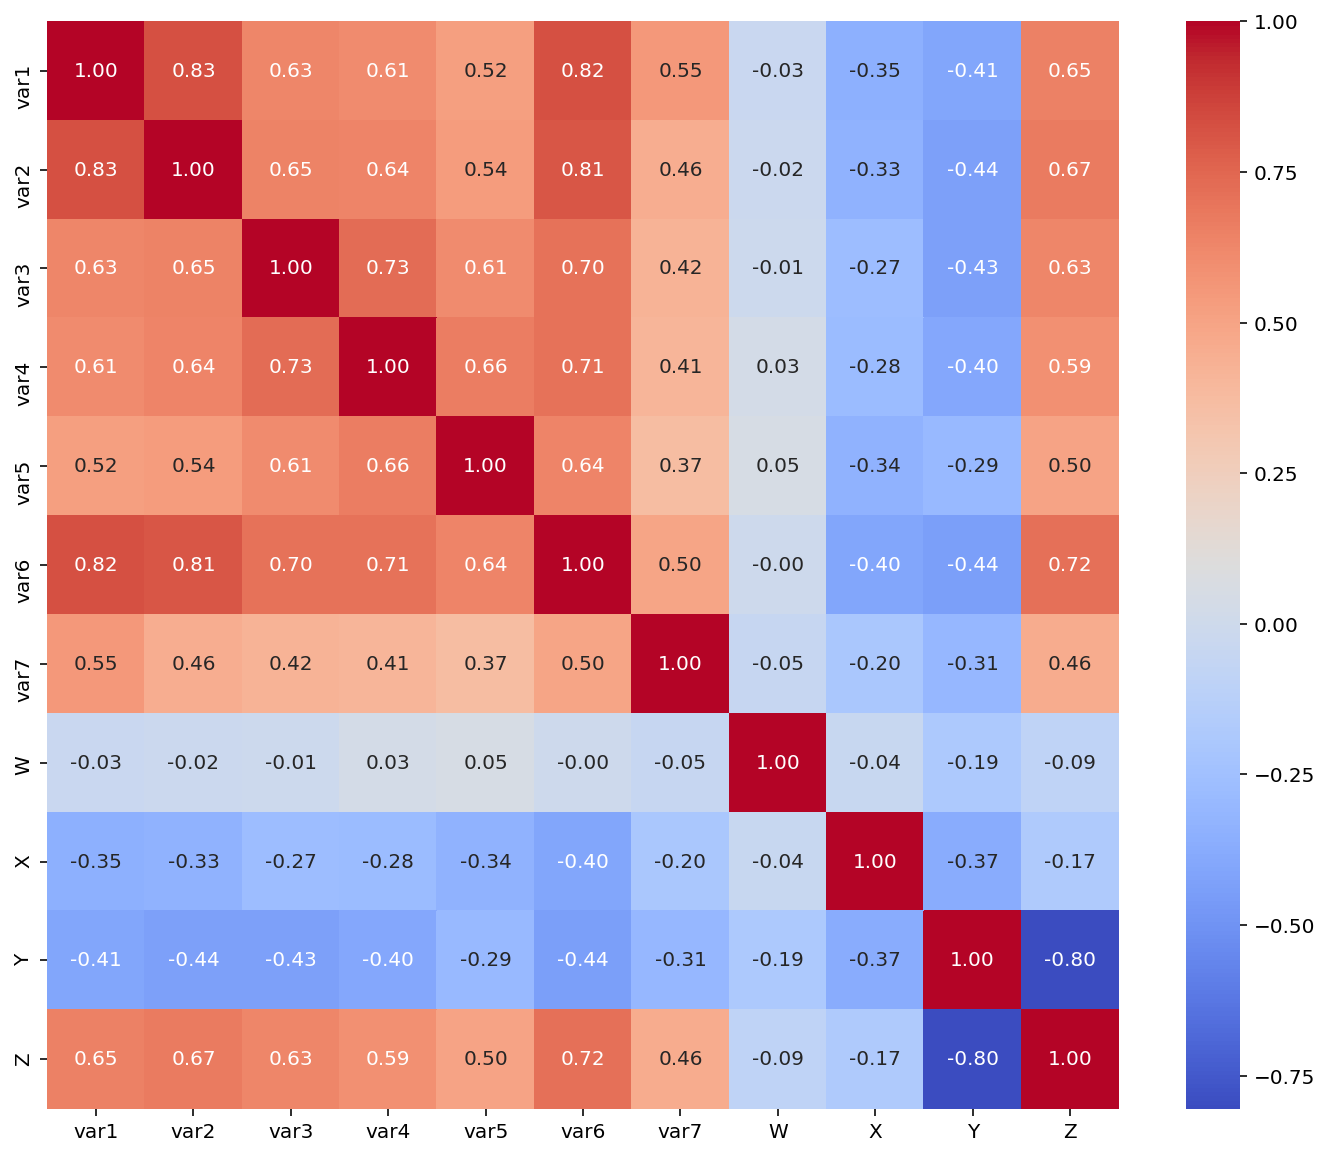

In [23]:
# Heat Graph of the correlation table for a quickier visualisation and understanding
plt.figure(figsize=(12,10))
sns.heatmap(df_corr, annot = True, fmt = ".2f", cmap = "coolwarm")

Now, the missing values, i.e. the one corresponding to W, seems to have a very weak linear correlation with the features we are going to study we decide to drop them. 

Obviously it is possible to proceed in a different way. We can train a classifier algorithm on the labelled examples, then predict the classification of the missing value and finally retrain the classifier including the new values. For a better accuracy it is probably better more than one classifier and than check the predictions before using them to train a third classifier.

However for the moment we decide to drop it. However to avoid to re-run everything in the case we decide to apply the second approach we decide drop the missing value from a copy of our dataframe. (This is definitely not optimal since we are wasting cache memory)

In [24]:
df1 = df
df1 = df1.drop(df1.index[df1['outcome'] == 'W'],axis = 0)
df1['outcome'].unique()

array(['Z', 'Y', 'X'], dtype=object)

Before proceed to the Machine Learning tasks, it is crucial to note the collinearity of the features. This in general lead to a more difficult interpretation of the statistical model but it has an extremely mild effect(mostly none) on the predictive power of the machine leraning classifier. We can plot also the scatter plot for a better visualisation of the collinearity

array([[<AxesSubplot:xlabel='var1', ylabel='var1'>,
        <AxesSubplot:xlabel='var2', ylabel='var1'>,
        <AxesSubplot:xlabel='var3', ylabel='var1'>,
        <AxesSubplot:xlabel='var4', ylabel='var1'>,
        <AxesSubplot:xlabel='var5', ylabel='var1'>,
        <AxesSubplot:xlabel='var6', ylabel='var1'>],
       [<AxesSubplot:xlabel='var1', ylabel='var2'>,
        <AxesSubplot:xlabel='var2', ylabel='var2'>,
        <AxesSubplot:xlabel='var3', ylabel='var2'>,
        <AxesSubplot:xlabel='var4', ylabel='var2'>,
        <AxesSubplot:xlabel='var5', ylabel='var2'>,
        <AxesSubplot:xlabel='var6', ylabel='var2'>],
       [<AxesSubplot:xlabel='var1', ylabel='var3'>,
        <AxesSubplot:xlabel='var2', ylabel='var3'>,
        <AxesSubplot:xlabel='var3', ylabel='var3'>,
        <AxesSubplot:xlabel='var4', ylabel='var3'>,
        <AxesSubplot:xlabel='var5', ylabel='var3'>,
        <AxesSubplot:xlabel='var6', ylabel='var3'>],
       [<AxesSubplot:xlabel='var1', ylabel='var4'>,
        <

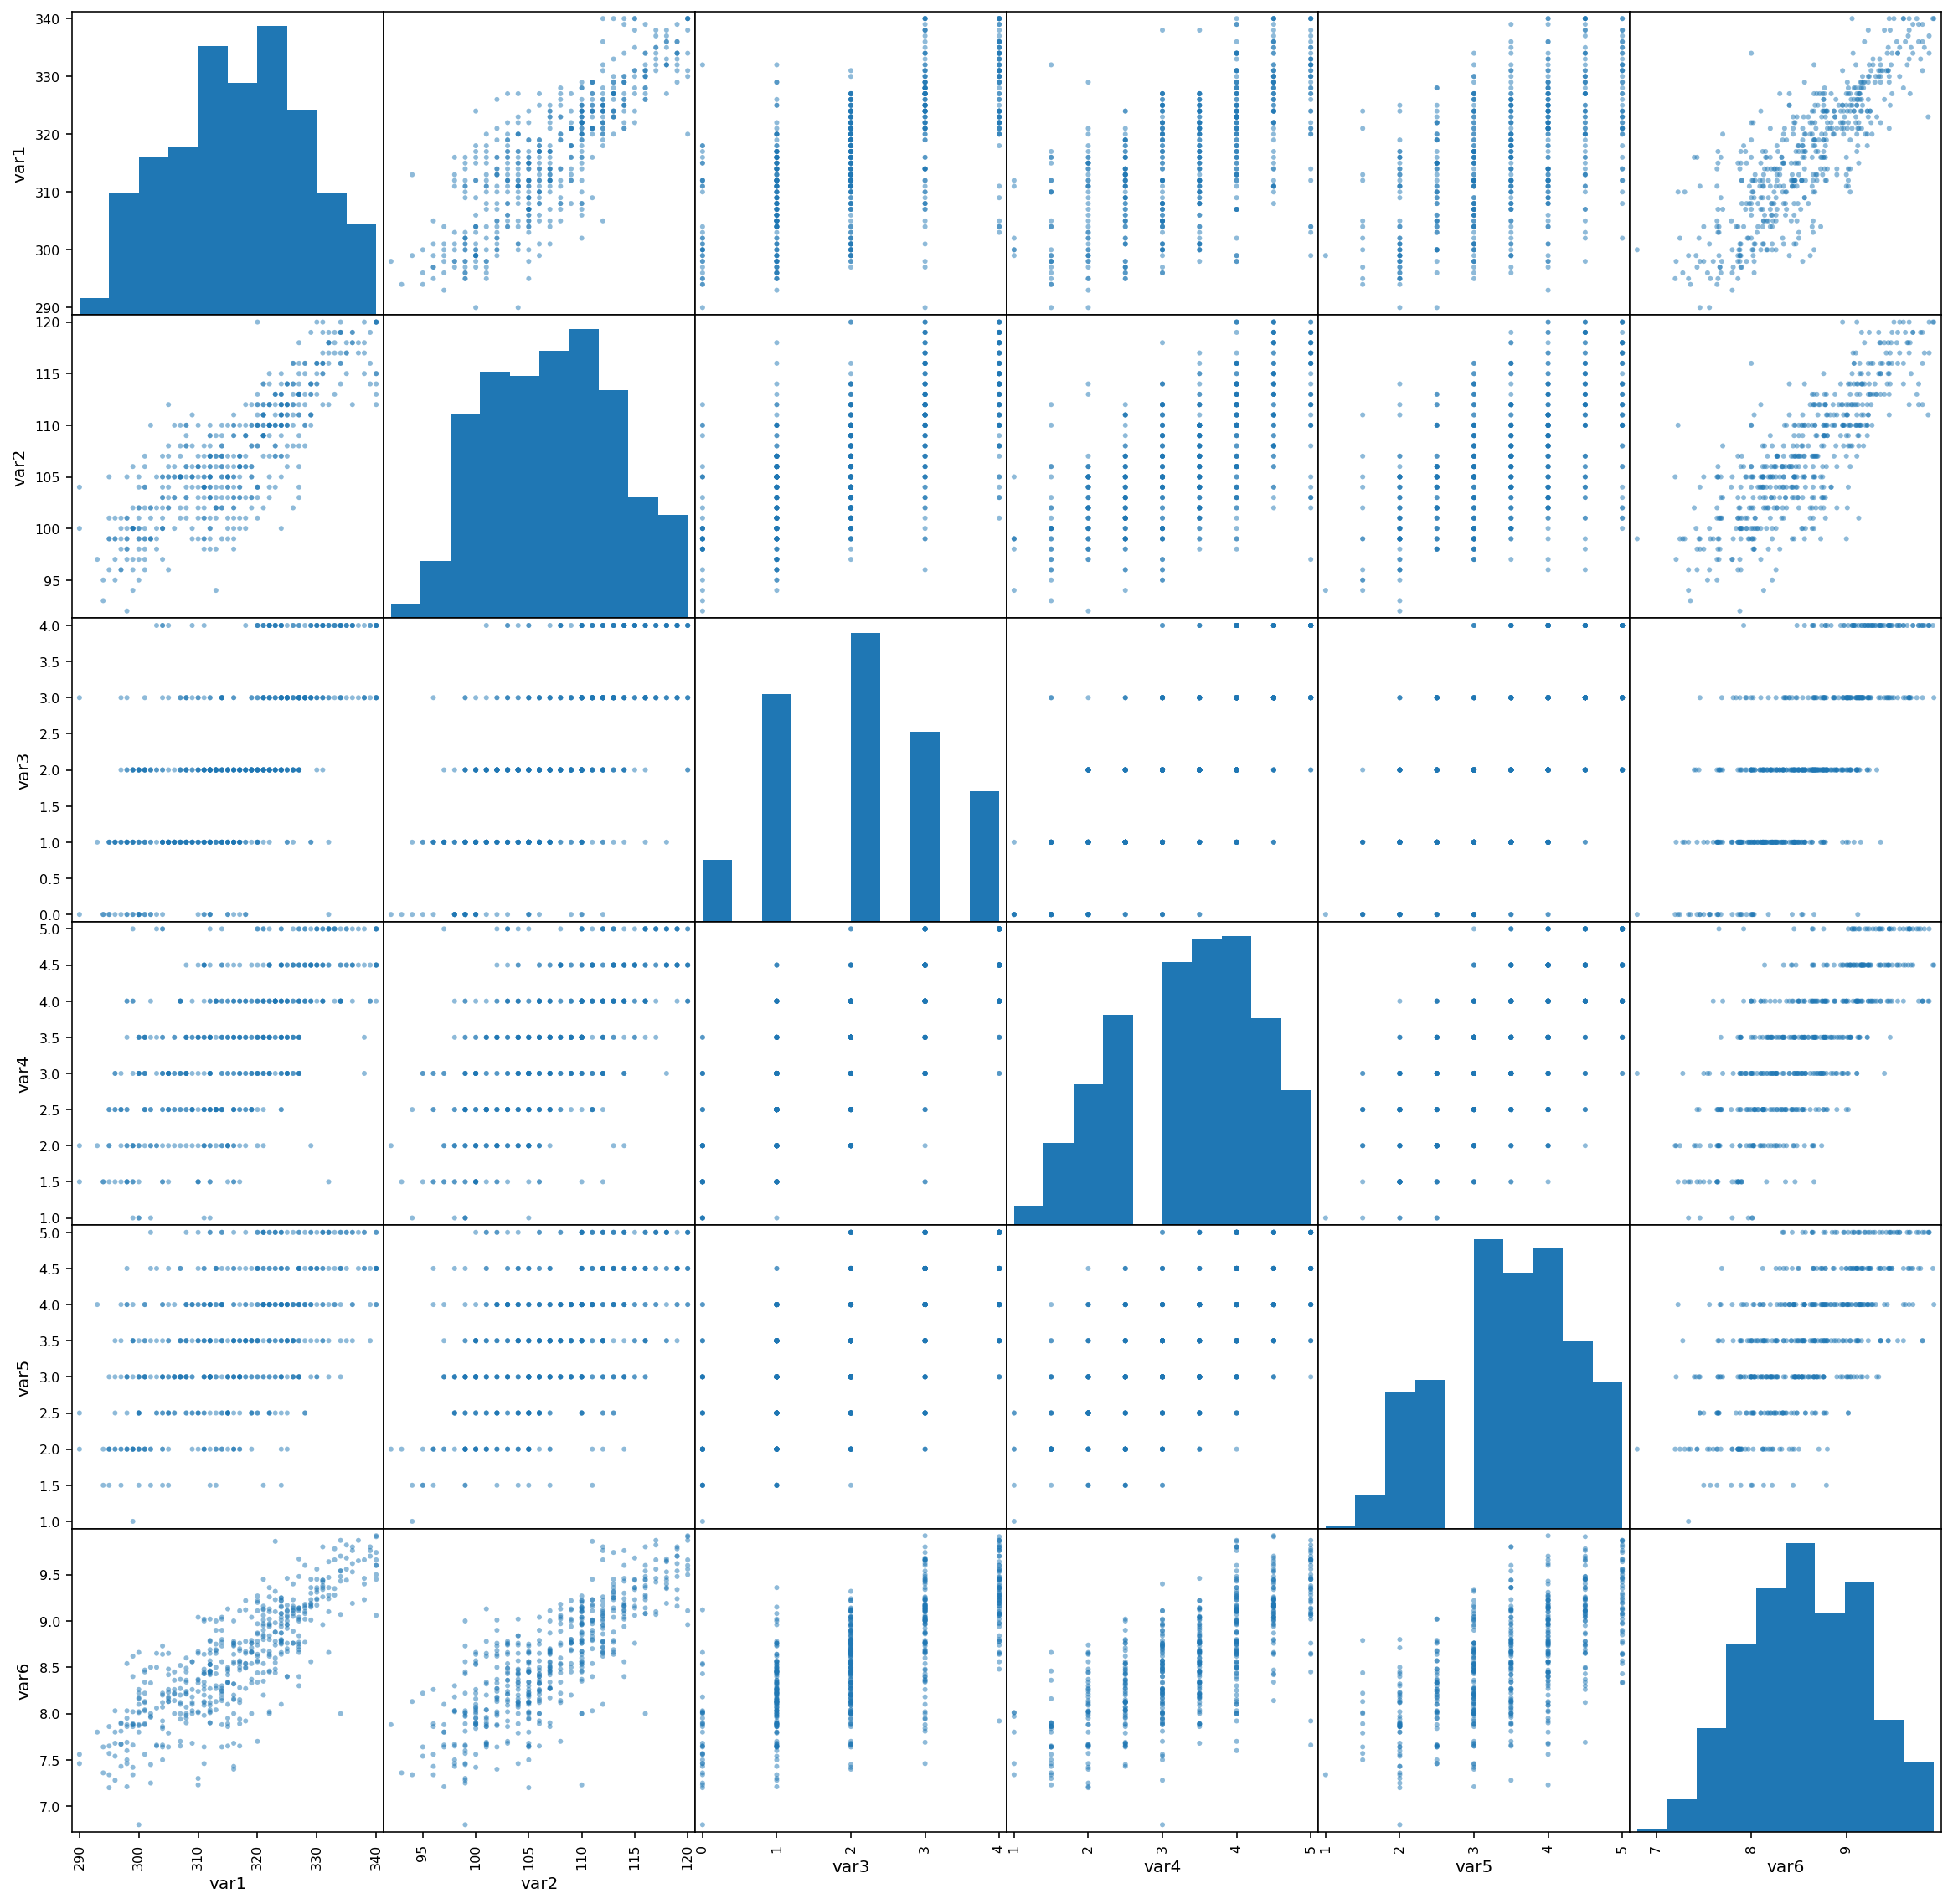

In [25]:
cols = ['var1','var2','var3','var4','var5','var6']
pd.plotting.scatter_matrix(df[cols], figsize=(20,20))


## Machine Learning Overall <a class="anchor" id="second-bullet"></a>



We have now cleaned and explored the data and we are ready for the Machine Learning (ML) task. 

We import the following tools and ML classifier. At the end of everything we will train also the Neural Network Classifier built from scatch by us.

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

All the algorithms we decided to use are able to deal with multivalued cathegorical variables. However, it will be useful for later having a multidimensional vector (a matrix) for the target variable $outcome$.

In [28]:
#features matrix
X = df1.drop(['outcome'], axis = 1)
#label vector
Y = df1['outcome']
display(X)
display(Y)
# matrix of labeled samples
num = {'X':0, 'Y':1, 'Z':2}
y = Y.map(num)
y = label_binarize(y, classes=[0,1,2])
display(y)

,var1,var2,var3,var4,var5,var6,var7
0,337.0,118.0,3,4.5,4.5,9.65,1
1,324.0,107.0,3,4.0,4.5,8.87,1
2,316.0,104.0,2,3.0,3.5,8.00,1
3,322.0,110.0,2,3.5,2.5,8.67,1
4,314.0,103.0,1,2.0,3.0,8.21,0
...,...,...,...,...,...,...,...
495,310.0,108.0,4,4.5,4.0,9.02,1
496,337.0,117.0,4,5.0,5.0,9.87,1
497,330.0,120.0,4,4.5,5.0,9.56,1
498,312.0,103.0,3,4.0,5.0,8.43,0


0      Z
1      Y
2      Y
3      Y
4      Y
      ..
495    Z
496    Z
497    Z
498    Y
499    Z
Name: outcome, Length: 487, dtype: object

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

Since we decide to study the dataset with several ML algorithms we need to decide which ones are worthed to be further trained. Since we are dealing with a classification problem the accuracy score is not the optimal indicator of how good the algorithm is actually performing. So we decide to use both the accuracy score and the f1-macro score. After picking the best ones we deal with them in more details (confusion matrix, ROC&AUC). Obviously we take the mean of the cross validation scores and since the algorithms are sensible to rescaling we use the function StandardsSCaler to perform it. Since we do not want any transmission of information between the training and the validation set we use the function make_pipeline to assert it.

In [29]:
def pipe_preproc(algorithm):
    normalised_data = make_pipeline(preprocessing.StandardScaler(), algorithm)
    return normalised_data

In [30]:
# Random Forest (normalisation)
rf = RandomForestClassifier(n_estimators = 200)
acc_sc_rf = cross_val_score(pipe_preproc(rf),X, y, cv=10, scoring = "accuracy")
F1_sc_rf = cross_val_score(pipe_preproc(rf),X, y, cv=10, scoring = "f1_macro")
print("Random Forest F1 Scores (100 estimators): {}, Mean: {}, Standard Deviation: {}".format(F1_sc_rf,F1_sc_rf.mean(),F1_sc_rf.std()))
print("Random Forest Accuracy Scores (100 estimators): {}, Mean: {}, Standard Deviation: {}\n".format(acc_sc_rf,acc_sc_rf.mean(),acc_sc_rf.std()))

# Stochastic Gradient Descent (normalisation)
sgd = linear_model.SGDClassifier(max_iter = 300, tol = None)
acc_sc_sgd = cross_val_score(pipe_preproc(sgd),X, Y, cv=10, scoring = "accuracy")
F1_sc_sgd = cross_val_score(pipe_preproc(sgd),X, Y, cv=10, scoring = "f1_macro")
print("Stochastic Gradient Descent F1 Scores (300 iterations): {}, Mean: {}, Standard Deviation: {}".format(F1_sc_sgd,F1_sc_sgd.mean(),F1_sc_sgd.std()))
print("Stochastic Gradient Descent Accuracy Scores (300 iterations): {}, Mean: {}, Standard Deviation: {}\n".format(acc_sc_sgd,acc_sc_sgd.mean(),acc_sc_sgd.std()))

# Perceptron (normalisation)
per = Perceptron(max_iter=100)
acc_sc_per = cross_val_score(pipe_preproc(per),X, Y, cv=10, scoring = "accuracy")
F1_sc_per = cross_val_score(pipe_preproc(per),X, Y, cv=10, scoring = "f1_macro")
print("Perceptron F1 Scores: {}, Mean: {}, Standard Deviation: {}".format(F1_sc_per,F1_sc_per.mean(),F1_sc_per.std()))
print("Perceptron Accuracy Scores: {}, Mean: {}, Standard Deviation: {} \n".format(acc_sc_per,acc_sc_per.mean(),acc_sc_per.std()))

# K-Nearest Neighbors Classifier (normalisation)
acc_sc_knn_bm = 0
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    acc_sc_knn = cross_val_score(pipe_preproc(knn),X, y, cv=10, scoring = "accuracy")
    if acc_sc_knn_bm <= acc_sc_knn.mean():
        acc_sc_knn_bm = acc_sc_knn.mean()
        acc_sc_knn_b = acc_sc_knn
        best_k = k

acc_sc_knn = acc_sc_knn_b
knn = KNeighborsClassifier(n_neighbors=best_k)
F1_sc_knn = cross_val_score(pipe_preproc(knn),X, y, cv=10, scoring = "f1_macro")
print("K-NN F1 Scores {} Neighbors: {}, Mean: {}, Standard Deviation: {}".format(best_k,F1_sc_knn,F1_sc_knn.mean(),F1_sc_knn.std()))
print("K-NN Accuracy Scores {} Neighbors: {}, Mean: {}, Standard Deviation: {}\n".format(best_k,acc_sc_knn,acc_sc_knn.mean(),acc_sc_knn.std()))

# Logistic Regression
lr = LogisticRegression(max_iter = 6000)
acc_sc_lr = cross_val_score(pipe_preproc(lr),X, Y, cv=10, scoring = "accuracy")
F1_sc_lr = cross_val_score(pipe_preproc(lr),X, Y, cv=10, scoring = "f1_macro")
print("Logistic Regression F1 Scores: {}, Mean: {}, Standard Deviation: {}".format(F1_sc_lr,F1_sc_lr.mean(),F1_sc_lr.std()))
print("Logistic Regression Accuracy Scores: {}, Mean: {}, Standard Deviation: {}\n".format(acc_sc_lr,acc_sc_lr.mean(),acc_sc_lr.std()))

# Gaussian Naive Bayes
gnb = GaussianNB()
acc_sc_gnb = cross_val_score(pipe_preproc(gnb),X, Y, cv=10, scoring = "accuracy")
F1_sc_gnb= cross_val_score(pipe_preproc(gnb),X, Y, cv=10, scoring = "f1_macro")
print("Gaussia Naive Bayes F1 Scores: {}, Mean: {}, Standard Deviation: {}".format(F1_sc_gnb,F1_sc_gnb.mean(),F1_sc_gnb.std()))
print("Gaussia Naive Bayes Accuracy Scores: {}, Mean: {}, Standard Deviation: {}\n".format(acc_sc_gnb,acc_sc_gnb.mean(),acc_sc_gnb.std()))

# Support Vector Machine Classifier (linear Kernel, normalisation)
lsvm = LinearSVC(max_iter = 200000)
acc_sc_lsvm = cross_val_score(pipe_preproc(lsvm),X, Y, cv=10, scoring = "accuracy")
F1_sc_lsvm= cross_val_score(pipe_preproc(lsvm),X, Y, cv=10, scoring = "f1_macro")
print("Linear Support Vector Machine F1 Scores: {}, Mean: {}, Standard Deviation: {}".format(F1_sc_lsvm,F1_sc_lsvm.mean(),F1_sc_lsvm.std()))
print("Linear Support Vector Machine Accuracy Scores: {}, Mean: {}, Standard Deviation: {}\n".format(acc_sc_lsvm,acc_sc_lsvm.mean(),acc_sc_lsvm.std()))

# Decision Tree (normalisation)
dt = DecisionTreeClassifier()
acc_sc_dt = cross_val_score(pipe_preproc(dt),X, y, cv=10, scoring = "accuracy")
F1_sc_dt= cross_val_score(pipe_preproc(dt),X, y, cv=10, scoring = "f1_macro")
print("Decision Tree F1 Scores: {}, Mean: {}, Standard Deviation: {}".format(F1_sc_dt,F1_sc_dt.mean(),F1_sc_dt.std()))
print("Decision Tree Accuracy Scores: {}, Mean: {}, Standard Deviation: {}\n".format(acc_sc_dt,acc_sc_dt.mean(),acc_sc_dt.std()))

Random Forest F1 Scores (100 estimators): [0.66727583 0.62596929 0.82525253 0.59191919 0.61257606 0.95813772
 0.68803419 0.69490969 0.60761905 0.96017316], Mean: 0.7231866704381733, Standard Deviation: 0.13387168707543043
Random Forest Accuracy Scores (100 estimators): [0.81632653 0.69387755 0.87755102 0.87755102 0.91836735 0.93877551
 0.83673469 0.77083333 0.91666667 0.95833333], Mean: 0.8605017006802722, Standard Deviation: 0.07816805757335024



Stochastic Gradient Descent F1 Scores (300 iterations): [0.61319444 0.58055556 0.59285024 0.59480376 0.62953139 0.58055556
 0.57301587 0.59461698 0.61615002 0.59514687], Mean: 0.5970420684621971, Standard Deviation: 0.01683594811432221
Stochastic Gradient Descent Accuracy Scores (300 iterations): [0.89795918 0.83673469 0.7755102  0.83673469 0.87755102 0.83673469
 0.81632653 0.875      0.89583333 0.85416667], Mean: 0.8502551020408162, Standard Deviation: 0.03607226647347629



Perceptron F1 Scores: [0.7851273  0.68576239 0.70322581 0.70655738 0.55228758 0.62453066
 0.54473304 0.70890269 0.5993266  0.5918408 ], Mean: 0.6502294247959073, Standard Deviation: 0.0750112540210455
Perceptron Accuracy Scores: [0.85714286 0.73469388 0.83673469 0.7755102  0.79591837 0.65306122
 0.79591837 0.8125     0.875      0.85416667], Mean: 0.7990646258503402, Standard Deviation: 0.06309535269623053 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.



K-NN F1 Scores 15 Neighbors: [0.56285311 0.62962963 0.58079625 0.63573232 0.6        0.88206388
 0.75457875 0.64641293 0.61002179 0.82275132], Mean: 0.6724839985003139, Standard Deviation: 0.10329155901985732
K-NN Accuracy Scores 15 Neighbors: [0.7755102  0.73469388 0.85714286 0.95918367 0.91836735 0.87755102
 0.87755102 0.79166667 0.91666667 0.91666667], Mean: 0.8625, Standard Deviation: 0.06909247772065194



Logistic Regression F1 Scores: [0.79451668 0.71851852 0.68241758 0.80730381 0.62953139 0.81218638
 0.75007215 0.72710997 0.78749029 0.87546296], Mean: 0.758460972735844, Standard Deviation: 0.06793991060107486
Logistic Regression Accuracy Scores: [0.89795918 0.85714286 0.81632653 0.87755102 0.89795918 0.87755102
 0.83673469 0.875      0.91666667 0.91666667], Mean: 0.8769557823129253, Standard Deviation: 0.031188014094324146



Gaussia Naive Bayes F1 Scores: [0.80996169 0.67586207 0.59850198 0.79137826 0.65392845 0.73300493
 0.71428571 0.7113903  0.71288566 0.77619048], Mean: 0.7177389527476666, Standard Deviation: 0.06139715449032121
Gaussia Naive Bayes Accuracy Scores: [0.87755102 0.79591837 0.73469388 0.85714286 0.79591837 0.7755102
 0.75510204 0.8125     0.8125     0.875     ], Mean: 0.8091836734693878, Standard Deviation: 0.04613822084498408



Linear Support Vector Machine F1 Scores: [0.62953139 0.58055556 0.52979664 0.59480376 0.62953139 0.58055556
 0.56016215 0.59461698 0.61615002 0.61160714], Mean: 0.5927310577959461, Standard Deviation: 0.02989832101489783
Linear Support Vector Machine Accuracy Scores: [0.89795918 0.83673469 0.7755102  0.85714286 0.89795918 0.83673469
 0.81632653 0.875      0.89583333 0.875     ], Mean: 0.8564200680272108, Standard Deviation: 0.038241701903460525



Decision Tree F1 Scores: [0.67954545 0.63578644 0.69183673 0.53122731 0.63464052 0.50527903
 0.69846154 0.77687217 0.48125118 0.59984943], Mean: 0.6234749800392876, Standard Deviation: 0.089728948727271
Decision Tree Accuracy Scores: [0.75510204 0.63265306 0.85714286 0.83673469 0.91836735 0.69387755
 0.83673469 0.8125     0.70833333 0.75      ], Mean: 0.7801445578231292, Standard Deviation: 0.08268884518696257



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.



In [31]:
models_score = pd.DataFrame({'Model' : ['Stochastic Gradiendt Descent','Random Forest', 'Logistic Regression', 'K-Nearest Neighbors', 'Gaussian Naive Bayes', 'Perceptron', 'Linear Support Vector Machine', 'Decision Tree Classifier'], 'Cross Validation Accuracy Score (mean)': [acc_sc_sgd.mean(),acc_sc_rf.mean(), acc_sc_lr.mean(), acc_sc_knn.mean(), acc_sc_gnb.mean(), acc_sc_per.mean(), acc_sc_lsvm.mean(),acc_sc_dt.mean()], 'Cross Validation F1 Score (mean)': [F1_sc_sgd.mean(),F1_sc_rf.mean(), F1_sc_lr.mean(), F1_sc_knn.mean(), F1_sc_gnb.mean(), F1_sc_per.mean(), F1_sc_lsvm.mean(),F1_sc_dt.mean()]})
models_score = models_score.sort_values(by = 'Cross Validation Accuracy Score (mean)', ascending = False)
models_score = models_score.set_index('Cross Validation Accuracy Score (mean)')
display(models_score)

,Model,Cross Validation F1 Score (mean)
Cross Validation Accuracy Score (mean),,
0.876956,Logistic Regression,0.758461
0.862500,K-Nearest Neighbors,0.672484
0.860502,Random Forest,0.723187
0.856420,Linear Support Vector Machine,0.592731
0.850255,Stochastic Gradiendt Descent,0.597042
0.809184,Gaussian Naive Bayes,0.717739
0.799065,Perceptron,0.650229
0.780145,Decision Tree Classifier,0.623475


From the tables we can then proceed to study further the Logistic Regression, Random Forest. K-Nearest Neighbors has an high accuracy score but really felt short in the F1-score we can analyse it a little bit more to see where the classification problem occurs.

### Detailed Random Forest <a class="anchor" id="third-bullet"></a>


Dealing with the Random Forest classifier we can have some insight about chich feature is used the most to perform a prediction.

,importance
feature,
var6,0.361
var1,0.200
var2,0.162
var3,0.088
var4,0.086
var5,0.075
var7,0.026


<AxesSubplot:xlabel='feature'>

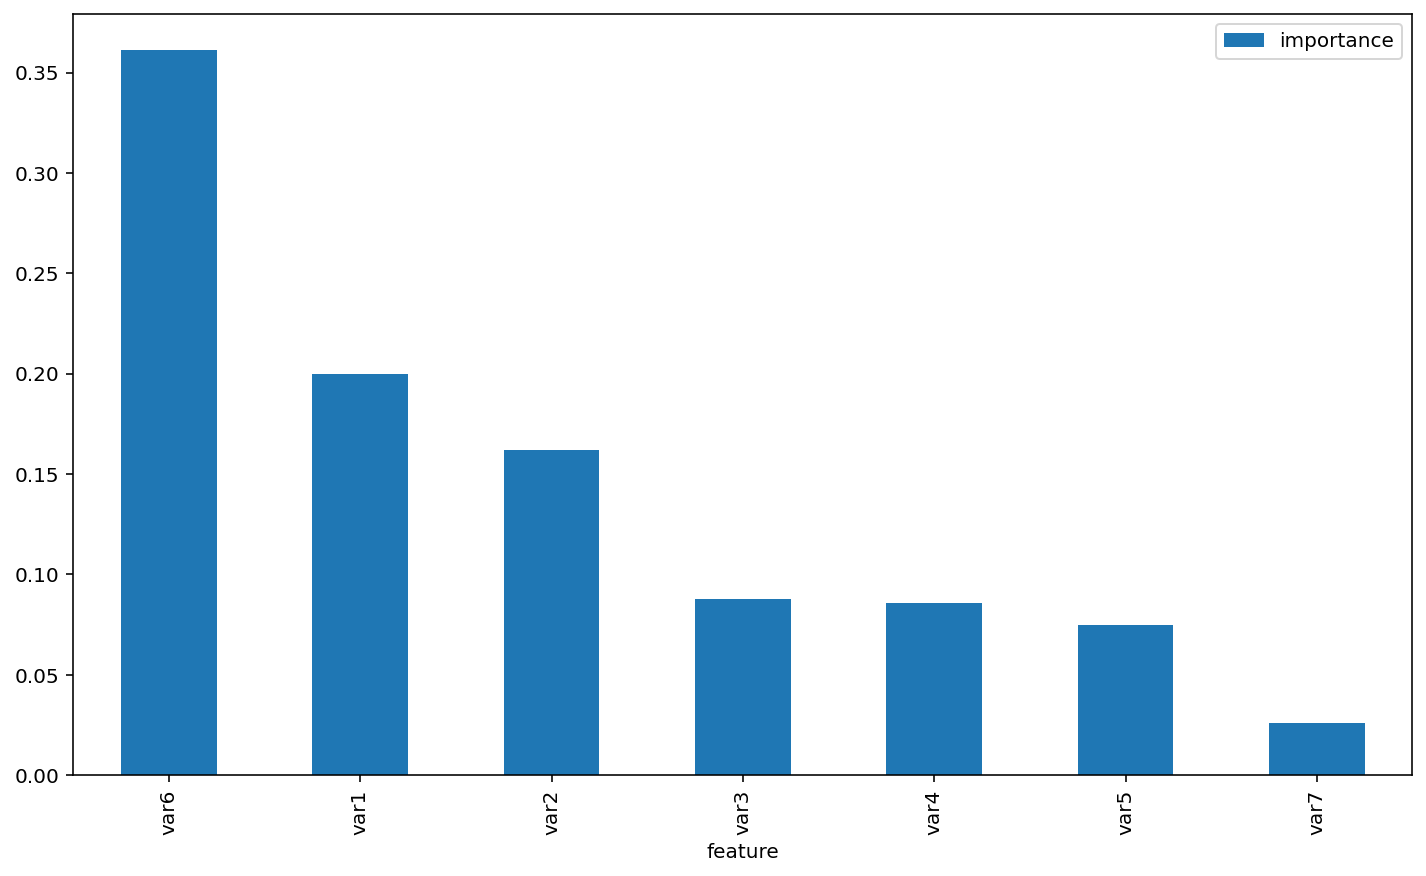

In [32]:
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(X,y)
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values(by= 'importance', ascending = False).set_index('feature')
display(importances)
importances.plot.bar()

We can also run the following algorithms to tune the Hyperparameters. Unfortunately, it is really power and time demanding so we cannot run it now.

We now look to the confusion matrix to see in more details our predictions. The diagonal contains the total correct predictions for the labels. The entri $a_{ij}$ determines how many time the $i$-th label is mis-predict as the $j$-th label. We can see that the Random forest perform very poorly in predicting outcome $X$ (it recognise it only 35% of the times). Moreover, it mistakenly label outcome $X$ only with the outcome $Y$ (Something that we can say from the correlation matrix of the previous part).

In [33]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(pipe_preproc(rf), X, Y, cv=3)
confusion_matrix(Y, predictions, labels=["X", "Y", "Z"])

array([[ 12,  25,   0],
       [  7, 293,  13],
       [  0,  22, 115]])

We can look also at the precision and recall score for each variable.

In [34]:
from sklearn.metrics import precision_score, recall_score
P = precision_score(Y, predictions, average = None)
R = recall_score(Y, predictions, average = None)
print("Precision:", P)
print("Recall:", R)

Precision: [0.63157895 0.86176471 0.8984375 ]
Recall: [0.32432432 0.93610224 0.83941606]


The last metric we are going to explore is the ROC Curve and the area under it (AUC). The curve gives very clear idea of the true positive rate vs false positive rate situation. The value of the area under the curve (AUC) is a score on how good our algorithm perform in the prediction. More the value is close to 1 the better. The value AUC = 0.5 means complete randomness in making the prediction.

In [35]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [36]:
n_classes = y.shape[1]
n_samples, n_features = X.shape
# Splitting in Train and tes set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=42)

In [37]:
X_train = (X_train-X_train.mean())/X_train.std() #normalisation
X_test = (X_test-X_test.mean())/X_test.std() #normalisation
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(X_train,y_train)
y_score = rf.predict(X_test)

The following code in an adaptation on the code presented in the scikit learn page on the ROC and AUC score.

In [38]:
def ROCandAUC_plots(n_classes,y_test, y_score, algorithm):
   # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class {} Receiver Operating Characteristic (ROC) & Area Under the Curve (AUC)'.format(algorithm))
    plt.legend(loc="lower right")
    plt.show()
    return None

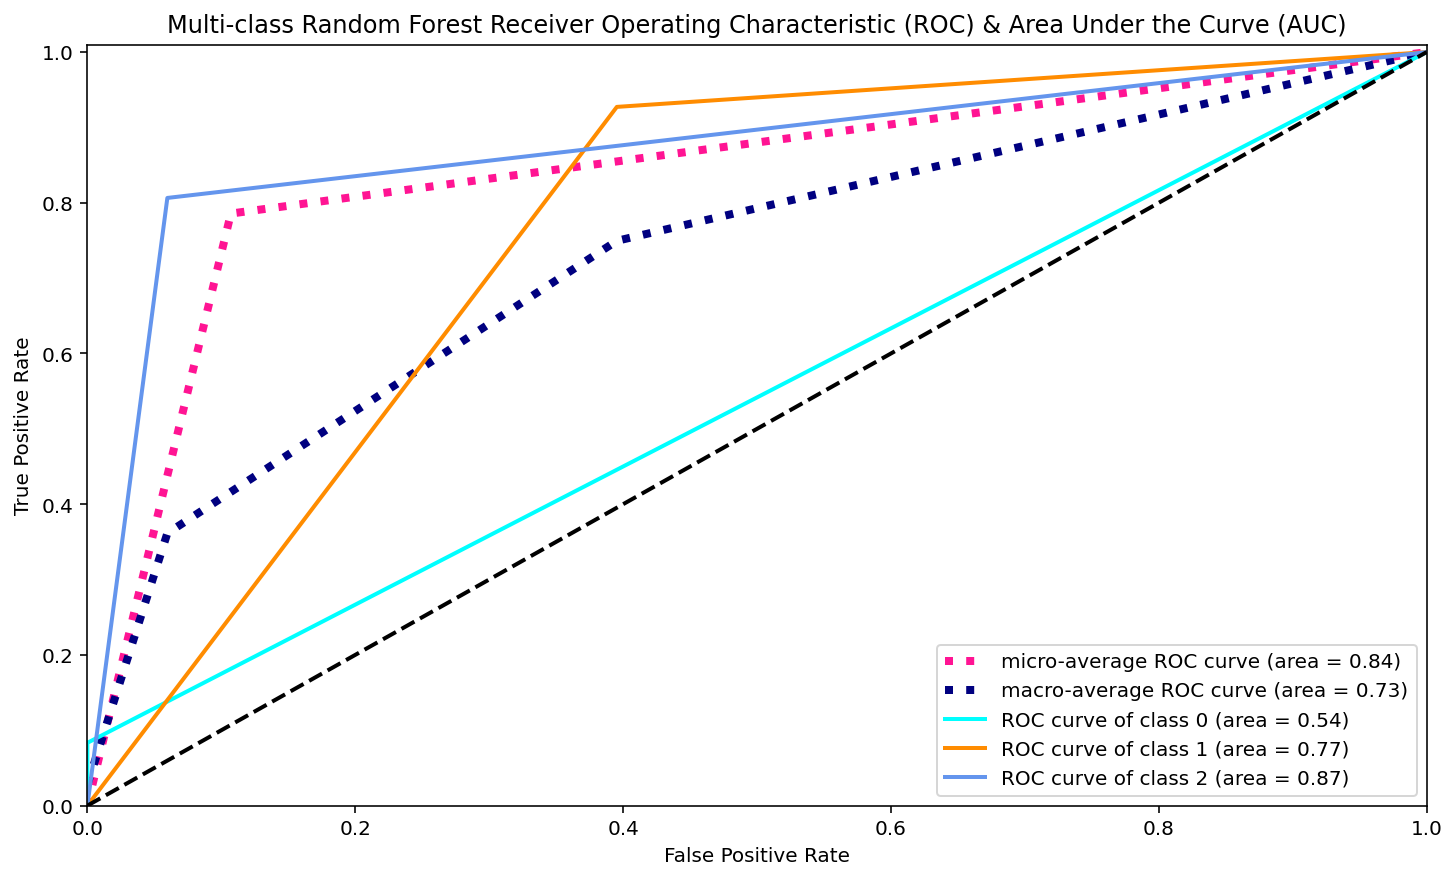

In [39]:
ROCandAUC_plots(n_classes,y_test, y_score, algorithm = 'Random Forest')

It is important to notice how close to be completely random is predicting X with the algorithm.

### Detailed K-Nearest Neighbors <a class="anchor" id="fourth-bullet"></a>

The K-NN Algorith had one of the highest accuracy score but the F1 scores showed deep problems. We do the same steps as in the detailed random forest.

In [40]:
knn = KNeighborsClassifier(n_neighbors=15)

In [41]:
predictions = cross_val_predict(pipe_preproc(knn), X, Y, cv=3)
confusion_matrix(Y, predictions, labels=["X", "Y", "Z"])

array([[  3,  34,   0],
       [  1, 301,  11],
       [  0,  24, 113]])

In [42]:
n_classes = y.shape[1]
n_samples, n_features = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=42)
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()
knn.fit(X_train,y_train)
y_score = knn.predict(X_test)

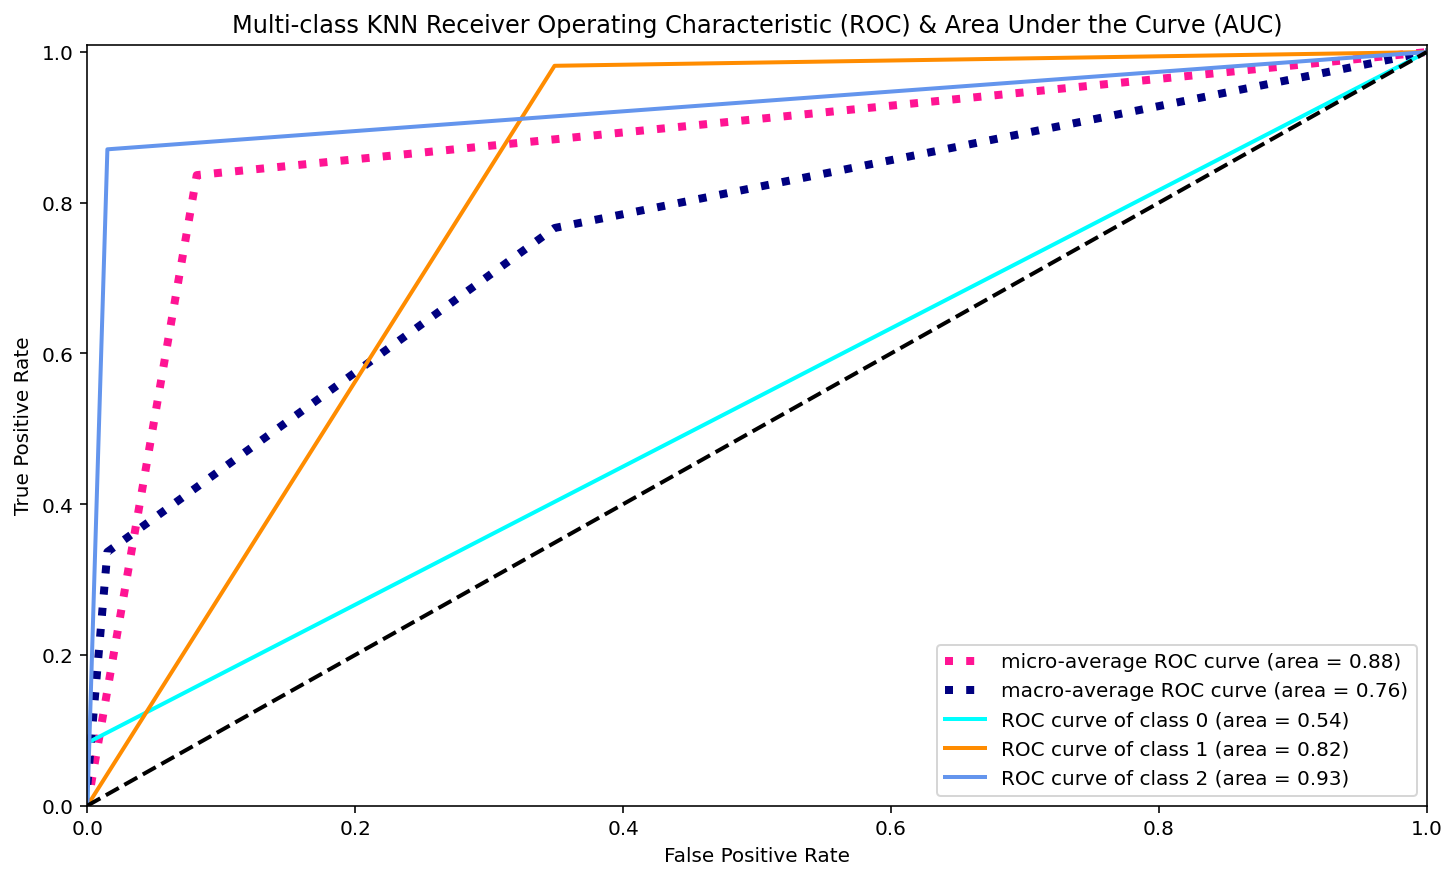

In [43]:
ROCandAUC_plots(n_classes,y_test, y_score, algorithm = 'KNN')

From this last plot is clear how close to a flip of a coin is the prediction of the outcome X by the KNN algorithm.

## Detailed Logistic Regression <a class="anchor" id="fifth-bullet"></a>

In [44]:
lr = LogisticRegression(max_iter = 5000)
predictions = cross_val_predict(pipe_preproc(lr), X, Y, cv=3)
confusion_matrix(Y, predictions, labels=["X", "Y", "Z"])

array([[ 13,  24,   0],
       [  6, 289,  18],
       [  0,  18, 119]])

In [45]:
n_classes = y.shape[1]
n_samples, n_features = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2,
                                                    random_state=42)
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()
lr.fit(X_train,y_train)
y_score = lr.predict(X_test)

In [46]:
y_score = np.array(label_binarize(pd.Series(y_score).map(num), classes=[0,1,2]))
y_test = np.array(label_binarize(pd.Series(y_test).map(num), classes=[0,1,2]))

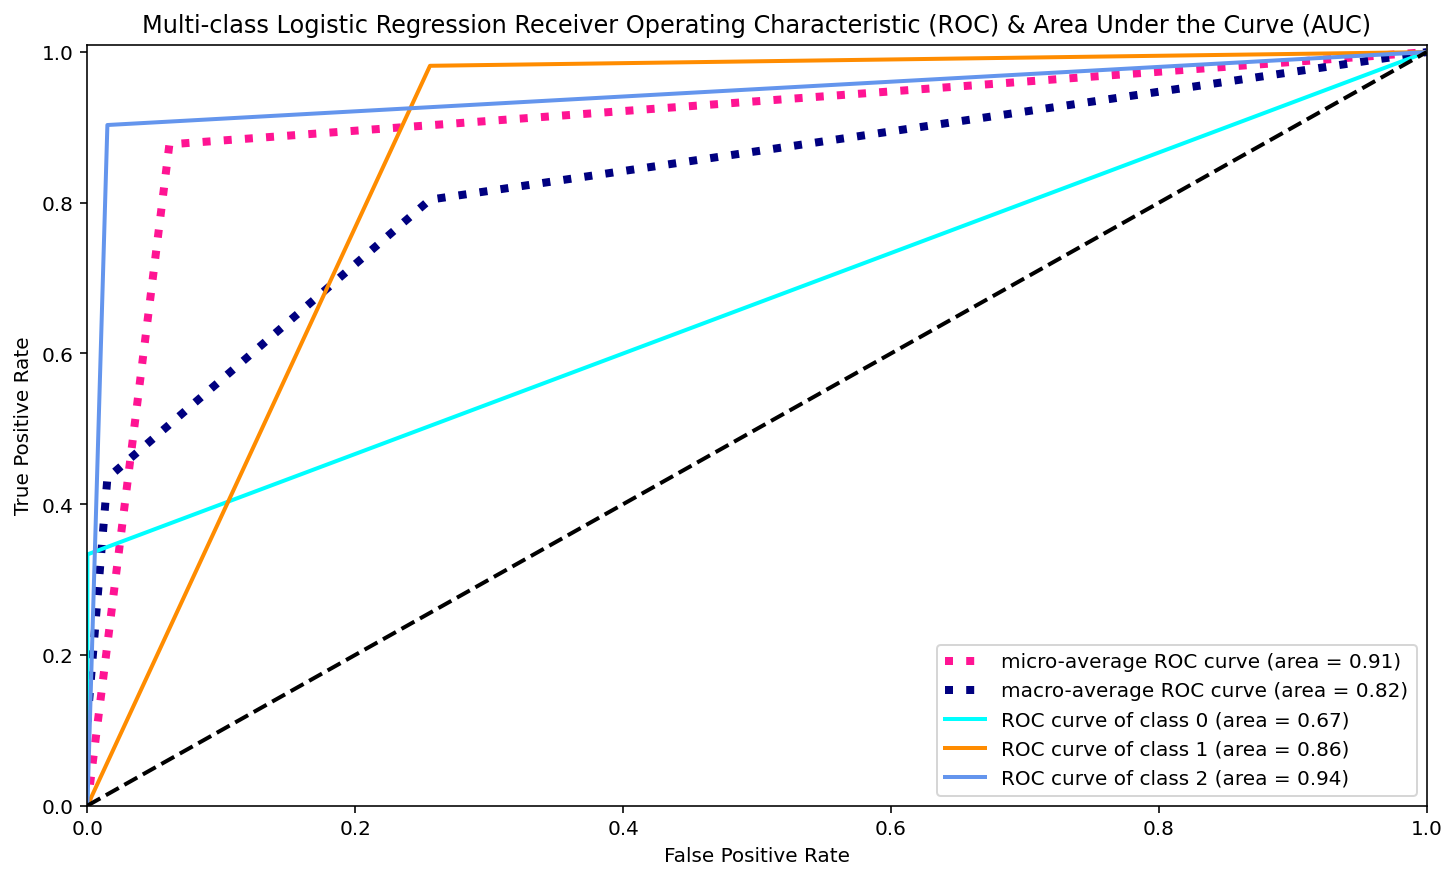

In [47]:
ROCandAUC_plots(n_classes,y_test, y_score, algorithm = 'Logistic Regression')

Even though we have a serious probem in labelling the outcome $X$ the logistic regression seems to be the best algorithm among the ones we tested.

## Learning Curve <a class="anchor" id="sixth-bullet"></a>

To see whether adding examples or features will help to improve the prediction we need to plot the learning curve. In case of High variance (overfitting) we need to regularise the cost function, and adding more training examples will improve the performance of the algorithm. On the other hand, if we have High Bias (underfitting) we need to add new features and adding new example it will be not very helpful.

None


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

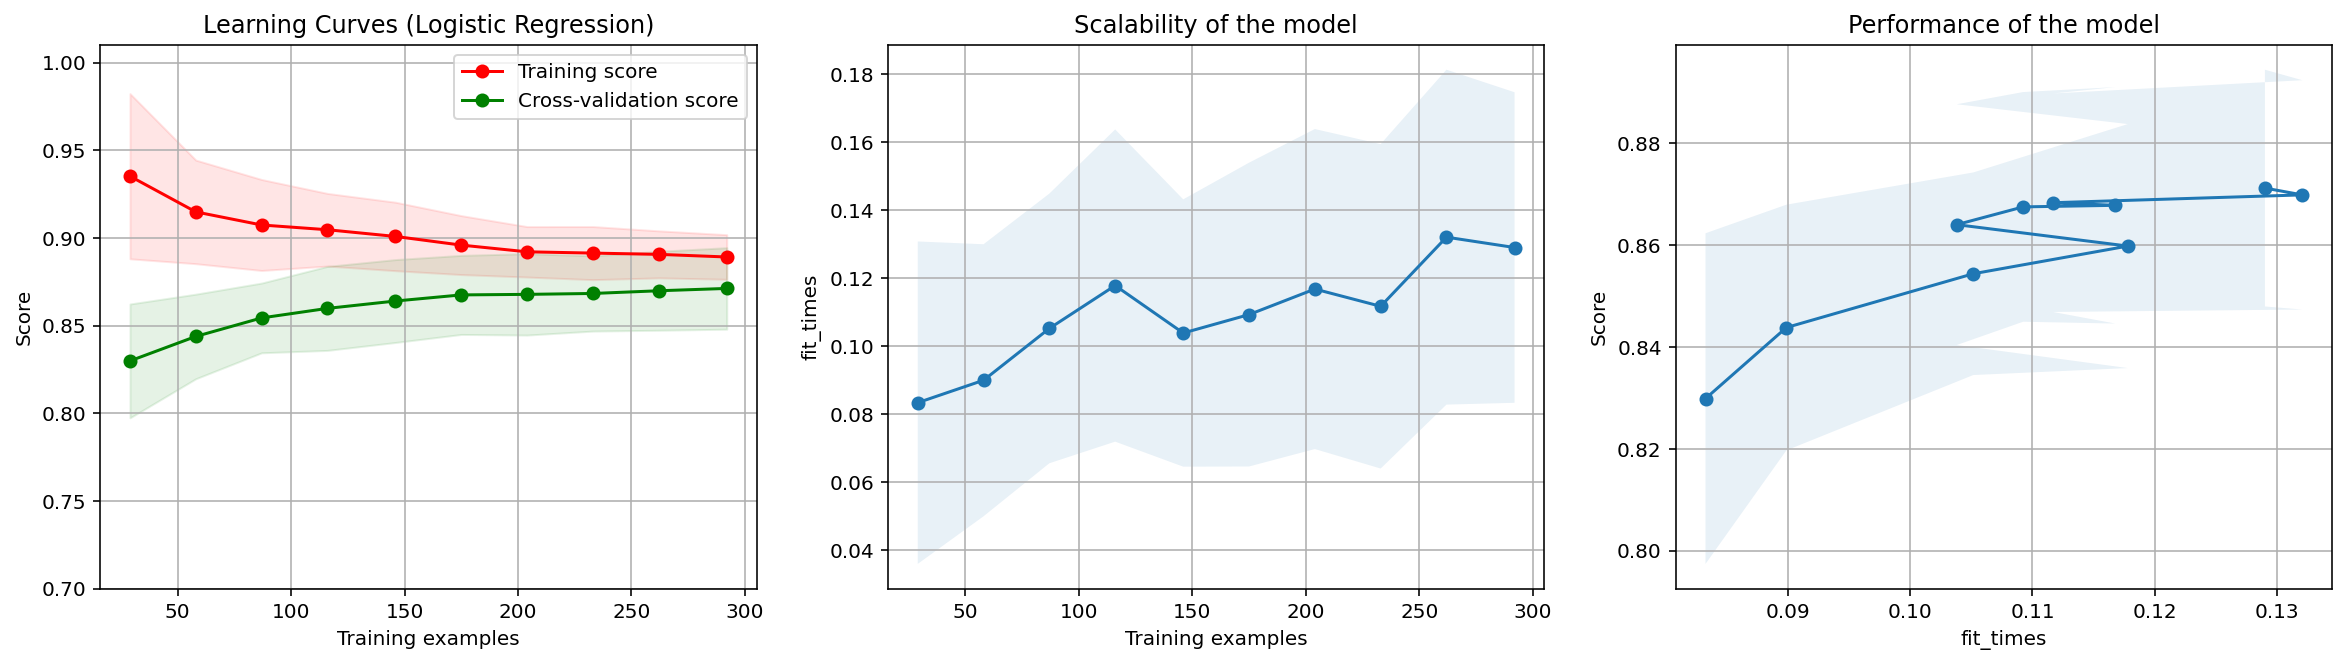

In [48]:
from PlotLearning import plot_learning_curve
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
# Random Forest #
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=50, test_size=0.4, random_state=42)
estimator = LogisticRegression(max_iter = 5000)
plot_learning_curve(pipe_preproc(estimator), title, X, Y, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

In our the learning curve shows no problem of underfitting or overfitting.

## Neural Network <a class="anchor" id="seventh-bullet"></a>

Here we show how a neural network built from scratch from us perform on the task. It is only preliminary since in the way is builded has not access on all the function we have used before. For the sake of completeness the last code cell of this notebook contains the code of the algorithm. We check how the different optimisation function perform.

In [49]:
from NN_Classifier_Python import NeuralNetwork_Classifier

In [50]:
nn = NeuralNetwork_Classifier([14])
num = {'X':0, 'Y':1, 'Z':2}
Ynn = Y.map(num)
X_train, X_test, y_train, y_test = train_test_split(X, Ynn, test_size=.2,
                                                    random_state=42, stratify= Ynn)
X_train = (X_train-X_train.mean())/X_train.std()
X_test = (X_test-X_test.mean())/X_test.std()

[14]


In [51]:
optimal_f = nn.fit(X_train, y_train, max_iter = 2000, Lambda = 0.3) # Lambda is the regularisation parameter
print('Score of fmin on Training set: {}'.format(round(nn.score(optimal_f, X_train,y_train)*100,2)))
print('Score of fmin on Test set: {}'.format(round(nn.score(optimal_f, X_test,y_test)*100,2)))

Optimization terminated successfully.
         Current function value: 0.539721
         Iterations: 934
         Function evaluations: 2042
         Gradient evaluations: 2042
Score of fmin on Training set: 93.57
Score of fmin on Test set: 87.76


As before the accuracy does not fully represent the performance of the algorithm. We display the confusion matrix and for the first time we see that the $outcome$ X is labelled right more times than when is mislabelled.

In [52]:
Xnn = (X-X.mean())/X.std()
input_layer_size = np.shape(Xnn)[1]
num_labels = len(np.unique(Ynn))
layers_data = [input_layer_size] + [14] + [num_labels]
prediction = nn.predict(optimal_f,layers_data,Xnn)
confusion_matrix(Ynn, prediction, labels=[0, 1, 2])

array([[ 22,  15,   0],
       [  2, 304,   7],
       [  0,  11, 126]])

Unfortunately in the remaining cases we completely mislabelled the outcome X.

In [53]:
optimal_B,_,theta_history_B = nn.fit(X_train, y_train, max_iter = 500, optim_fun = 'GradDesc', learning_rate = 0.015, momentum = 0.9)
print('Score of BGD on Training set: {}'.format(round(nn.score(optimal_B, X_train,y_train)*100,2)))
print('Score of BGD on Test set: {}'.format(round(nn.score(optimal_B, X_test,y_test)*100,2)))

The value of the cost function is: 0.8061212103002804
Score of BGD on Training set: 84.83
Score of BGD on Test set: 87.76


In [54]:
prediction = nn.predict(optimal_B,layers_data,Xnn)
confusion_matrix(Ynn, prediction, labels=[0, 1, 2])

array([[  0,  37,   0],
       [  0, 294,  19],
       [  0,  15, 122]])

In [55]:
optimal_MB,_,theta_history_MB = nn.fit(X_train, y_train, max_iter = 300, optim_fun = 'GradDesc', learning_rate = 0.0015, momentum = 0.8, num_batches = 100)
print('Score of MBGD on Training set: {}'.format(round(nn.score(optimal_MB, X_train,y_train)*100,2)))
print('Score of MBGD on Test set: {}'.format(round(nn.score(optimal_MB, X_test,y_test)*100,2)))

The value of the cost function is: 0.4342738815651384
Score of MBGD on Training set: 86.38
Score of MBGD on Test set: 85.71


In [56]:
prediction = nn.predict(optimal_MB,layers_data,Xnn)
confusion_matrix(Ynn, prediction, labels=[0, 1, 2])

array([[  0,  37,   0],
       [  0, 301,  12],
       [  0,  17, 120]])

In [57]:
optimal_S,_,theta_history_S = nn.fit(X_train, y_train, max_iter = 30, optim_fun = 'GradDesc', learning_rate = 0.0015, momentum = 0.3, num_batches = len(X_train))
print('Score of MBGD on Training set: {}'.format(round(nn.score(optimal_S, X_train,y_train)*100,2)))
print('Score of MBGD on Test set: {}'.format(round(nn.score(optimal_S, X_test,y_test)*100,2)))

The value of the cost function is: 0.4605878974685945
Score of MBGD on Training set: 85.35
Score of MBGD on Test set: 84.69


In [58]:
prediction = nn.predict(optimal_S,layers_data,Xnn)
confusion_matrix(Ynn, prediction, labels=[0, 1, 2])

array([[  0,  37,   0],
       [  0, 293,  20],
       [  0,  15, 122]])

To see whether we are overfitting or underfitting the problem we plot the learning curve. We apply it to the Batch Gradient descent optimisation.

In [59]:
hidden_layers = [14]
nn = NeuralNetwork_Classifier(hidden_layers)
def learningCurve(X,Y,max_iter = 100, learning_rate = 0.01, momentum = 0.99, batch_size = 1, Lambda = 0):
    learning_curve = []
    X_t, X_valid, Y_t, Y_valid = train_test_split(X, Y, test_size=0.20, random_state=1, stratify = Y)
    X_t = (X_t-X_t.mean())/X_t.std()
    X_valid = (X_valid-X_valid.mean())/X_valid.std()
    train_sizes=np.linspace(10, np.shape(X_t)[0], 1000)
    for i in train_sizes:
        data_train = np.hstack((X_t,np.array(Y_t)[np.newaxis].T))
        data_valid = np.hstack((X_valid,np.array(Y_valid)[np.newaxis].T))
        np.random.shuffle(data_train)
        np.random.shuffle(data_valid)
        X_tr = data_train[:int(i),:-1]
        Y_tr = np.array(data_train[:int(i),-1])
        X_val = data_valid[:int(i),:-1]
        Y_val = np.array(data_valid[:int(i),-1])
        n_batch = int(np.shape(X_tr)[0]//(np.shape(X_tr)[0]*batch_size))

        layers_info = [np.shape(X_tr)[1]] + hidden_layers + [2]
        optimal,Cost_history,theta_history = nn.fit(X_tr, Y_tr, max_iter = max_iter, Lambda = Lambda, learning_rate = learning_rate, momentum=momentum, optim_fun = 'GradDesc', num_batches = n_batch, verbose = False)
        learning_curve.append((Cost_history[-1], nn.cost_func_NN(optimal, layers_info, X_val, Y_val),int(i)))
    return learning_curve

[14]


In [60]:
BGD_curve = learningCurve(X,Ynn,max_iter = 500, learning_rate = 0.015, momentum = 0.9) #rerunning it will take a lot of time! decrease the train sizes in the learning curve function.

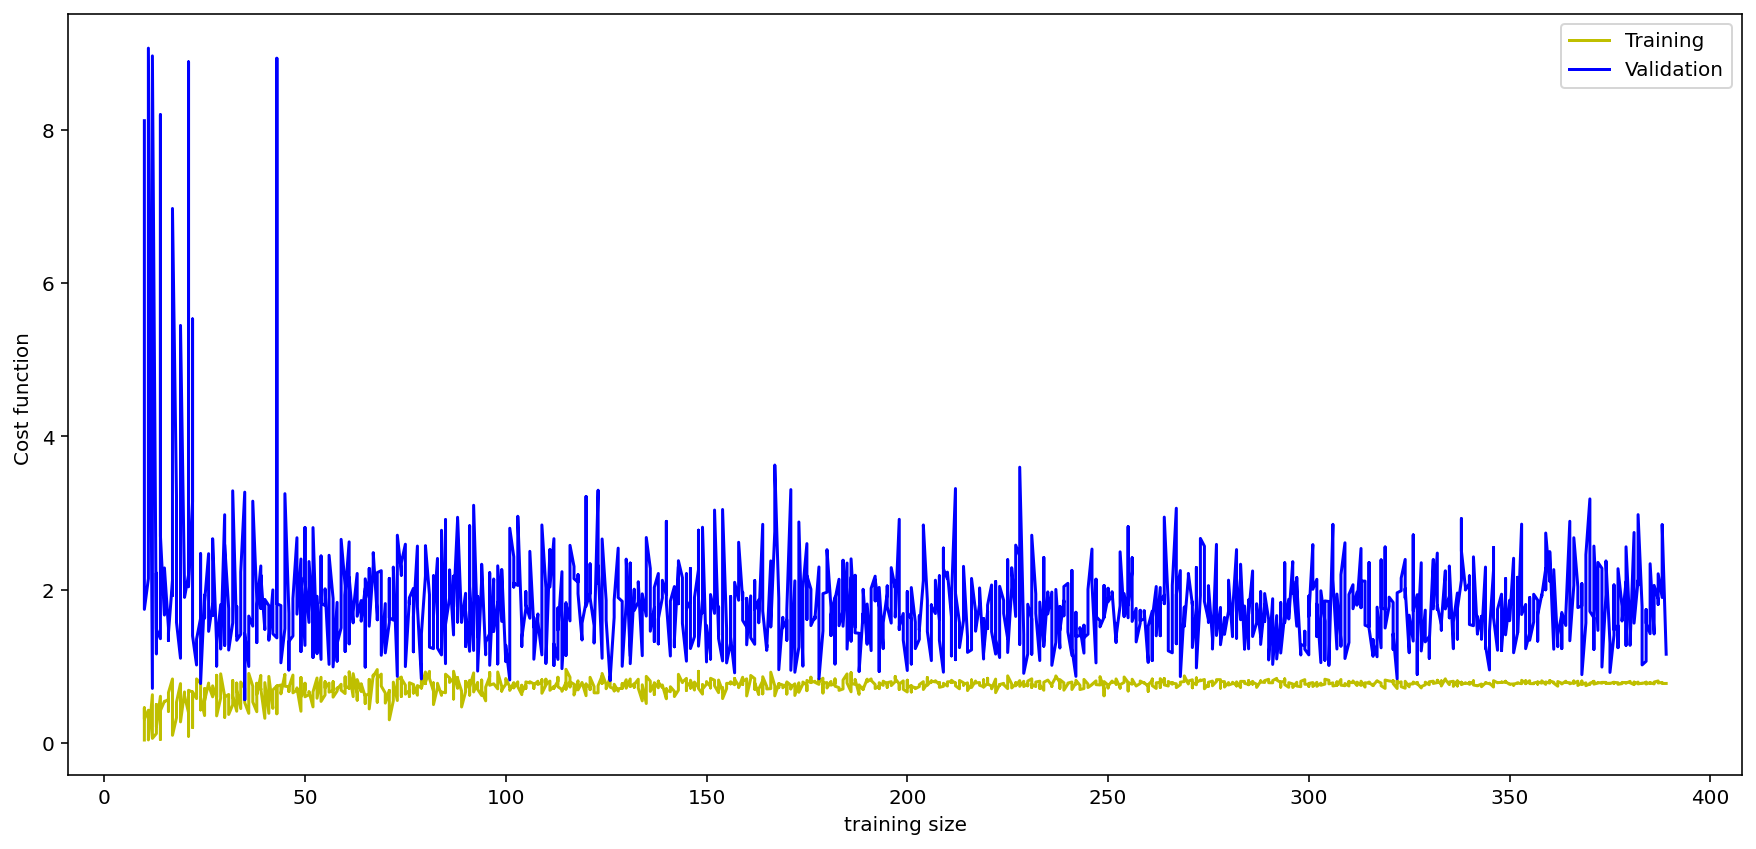

In [61]:
plt.figure(figsize = (15,7))
plt.plot([x[2] for x in BGD_curve],[x[0] for x in BGD_curve],'y', label = 'Training')
plt.plot([x[2] for x in BGD_curve],[x[1] for x in BGD_curve],'b', label = 'Validation')
#plt.plot(valid, 'b', label = 'validation')
plt.xlabel('training size')
plt.ylabel('Cost function ')
#plt.xticks()
plt.legend()

## Conclusion <a class="anchor" id="eight-bullet"></a>

In conclusion we have seen that out of the box the Logistic regression is the one with better overall performance and with the Best Precision and Recall Tradeoff. It has a big issue though in recognising one of the possible outcomes. To avoid this problem we have then trained a Neural Network completely built from scratch, and with the fmin_cg optimisation algorithm we have seen that we actually have not only comparable accuracy with the Logistic regression, but we are able to recognise the outcome X more consistently indeed.

A little experimentation with the hyperparameter of our Neural Network shows that it is possible to have 30 out of 7 correct classifications of X. On the other hand, the NN will have 100% accuracy on the training set and only the 75% accuracy on the test set. Thus it is most probably overfitting the data.

Finally, if we want to improve the precision vs recall score of the Logistic Regression we need to tweak the threshold value. On the other hand changing that probability value we are entering the realm of decision making. Without knowing what we are actually trading off (why we would like a better recognition of X against maybe a little loss of Y?) we decide to stop here and decide with the group and client which goal we actually really want to reach.

### Neural Network Classifier Code

In [62]:
import numpy as np 
from scipy.optimize import fmin_cg

class NeuralNetwork_Classifier(object):

    forwardProp = None

    def __init__(self,hidden_layers = [2]):
        self.hidden_layers_size = hidden_layers
        print(self.hidden_layers_size)

    def sigmoid(self,X):
        """
        It returns the sigmoid function applied to the matrix X. X may have any shape.
        """
        sig = 1/(1+np.exp(-X))
        return sig

    def sigmoidGradient(self,X):
        """
        It returns the derivative of the sigmoid function calculated at X. X is a matrix and may have any shape.
        """
        sig_g = self.sigmoid(X)*(1-self.sigmoid(X))
        return sig_g

    def Rand_param_Theta(self,In_value, Out_value):
        """
        It returns a (Out_value x In_value+1) random matrix with small entries.
        """
        epsilon_init = 0.12
        Rand_param = np.random.rand(Out_value, In_value+1) * 2 * epsilon_init - epsilon_init
        return Rand_param


    def predict(self,nn_params, layers_data, X, min_class_pred = 0):
        """
        The function returns a vector with the classification prediction for the set X.
        min_class_pred identify the smaller integer in the classification and must be adjusted accordingly to your
        classification labels. For instance if your labels are 1-10 you need to set min_class_pred =1. This is because
        the predictions are obtained from the indeces of a matrix and python as base index 0. By default it is setted
        on zero.
        """
        Theta_vec = self.reshape_thetas(nn_params, layers_data) 
        m = np.shape(X)[0]
        h_pred = [0 for i in range(len(Theta_vec)+1)]
        h_pred[0] = np.hstack((np.ones(m)[np.newaxis].T, X))
        for i in range(len(h_pred)-1):
            h = self.sigmoid(h_pred[i]@Theta_vec[i].T)
            if i == len(h_pred)-2:

                h_pred[i+1] = h                                           # h_pred[-1] is a (num_exp x num_label) matrix. The entry (i,j) contains the probabilities
                                                                          # that the i-th experiment is classified with label j
            else:
                h_pred[i+1] = np.hstack((np.ones(m)[np.newaxis].T, h))

        return np.argmax(h_pred[-1],axis = 1)+min_class_pred

    def score(self,nn_params, X, Y):
        """
            It return the accuracy of the Neural Network given the parameter vector nn_params, the expereiments matrix X
            and the label vector Y.
        """
        X = np.array(X)
        Y = np.array(Y)
        input_layer_size = np.shape(X)[1]        #recovering the input units from the experimental matrix
        num_labels = len(np.unique(Y))           #recovering the number of labels from the data stored in the label vector Y
        layers_data = [input_layer_size] + self.hidden_layers_size + [num_labels]         # a vector that contains the info about the units of all the layers
        min_class_pred = np.unique(Y)[0]

        pred =  self.predict(nn_params, layers_data, X, min_class_pred)
        if np.ndim(Y) ==1: Y = Y[np.newaxis]
        if np.shape(Y)[1] == 1:
            Y = Y.T                                         # Reshape Y in a row vector in order to perform boolean operation

        return(pred == Y).mean()

    def reshape_thetas(self,nn_params,layers_data):
        """
        Given a vector v and a list of integers L of lenght n it will returns a list of n-1 matrices exatrapolated by the vector v.
        The shape of a returned matrix is (j x (i+1)) where [...,i,j,..] are two consecutive entries of the list L.
        If it will not be possible automatically rise an Error. The order to reshape the matrices is F = Fortran.
        """
        T_list = []
        start_ind = 0
        for m,n in zip(layers_data,layers_data[1:]):
            dum = np.reshape(nn_params[start_ind:start_ind+n*(m+1)], (n, m+1), order = 'F')
            T_list.append(dum)
            start_ind = start_ind + n*(m+1)
        return T_list

    def  ForwardProp(self,nn_params, layers_data, X, Y, class_range = [0,1]):
        """
        It compute the Forward Propagation of the Neural Network.
        It returns
                -a_vec : a vector containing the computed value of the units for each layer.
                        Therefore a_vec[0] are the input units + bias, while a_vec[-1] are
                        the outputs units without the bias to use in the activation function.

               - z_vec : contains the values of the activation function at each unit of the layer
                         excluded the output ones.

               - Y : is a label Matrix of zeroes and ones. Column j has value 1 in i-th position
                     if i is the value of the j-th entries of Y. If it is not a "row" vector it will
                     be reshape into one

               - Theta_vec : is the list of the weights matrices.
        """
                    ### UTILITIES ###
        if self.forwardProp is None:
            Theta_vec = self.reshape_thetas(nn_params, layers_data)                 # recover the weights matrices from the weights vector

            m = np.shape(X)[0]                                                 # number of experiments
            min_class = class_range[0]                                         # smallest value occurring in the classification
            max_class = class_range[-1]                                        # larger alue occurring in the classification


                        ### CLASSIFICATION MATRIX ###
            I = np.repeat([np.arange(min_class, max_class +1)],m,0).T          # Classification Matrix
            if np.ndim(Y) == 1:
                Y = Y[np.newaxis]
            if np.shape(Y)[1] == 1:
                Y = Y.T                                          # Reshape Y in a row vector in order to perform boolean operation

            Y = np.array(I == Y).astype(int)                                   # Matrix of zeroes and ones of the labels. Column j has value 1 in i-th position if i is the value of the j-th entries of Y.



            ### FORWARD ROPAGATION ###
            J = 0                                                  # Initialise the cost Function J
            a1 = np.hstack((np.ones(m)[np.newaxis].T, X))          # Add the bias Column at the Input Layer
            a_vec = [0 for i in range(len(layers_data))]           # Initialise the units vector
            z_vec = [0 for i in range(len(layers_data)-1)]         # Initialise the activation function vector
            a_vec[0] = a1.T

            for i in range(len(layers_data)-1):
                zi = Theta_vec[i]@a_vec[i]                  # comupte z(i)
                z_vec[i] = zi
                ai = self.sigmoid(zi)                            # Values of the unit at layer (i)
                mi = np.shape(ai)[1]
                if i != len(layers_data)-2:
                    a_i_bias = np.vstack((np.ones(mi), ai)) # Add the Bias Column at the units
                    a_vec[i+1] = a_i_bias
                else:
                    a_vec[i+1] = ai

            forwardProp = a_vec, z_vec, Y,Theta_vec

        return forwardProp


    def cost_func_NN(self,nn_params, layers_data, X, Y, class_range = [0,1], Lambda =0):
        """
          The function has input:
            - nn params  : a vector of weights parameters
            - layers_data: a list containing the number of units at each layer (input and output included)
            - X : the training set matrix X
            - Y : the label vector Y
            -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                     The maximum value determines also how many values the Neural Network need to
                                     classify. By default it is setted as a binary 0,1 classifier.
            - J : the regularisation parameter, by default is zero
         The algorithm is vectorised and will return the value of the cost function J on the output layer.
        """

        m = np.shape(X)[0]
        a,_,Y,Theta_vec = self.ForwardProp(nn_params, layers_data, X, Y, class_range)   #computing the units values, the label matrix Y and the weights matrices
        a_out = a[-1]  # the output units of the Neural Network

        reg = (Lambda/(2*m))*(sum([(Theta[:,1:]*Theta[:,1:]).sum() for Theta in Theta_vec])) #regolarisation factor

        J = (1/m) * (((-Y * np.log(a_out))-((1-Y) * np.log(1-a_out))).sum()) + reg           #formula for the regularised cost function

        return(J)



    def grad_NN(self,nn_params,layers_data, X, Y, class_range = [0,1], Lambda =0):
        """
        It compute the Backward Propagation and gradient of the Neural Network.
        The function as input
            - nn params  : a vector of weights parameters
            - layers_data: a list containing the number of units at each layer (input and output included)
            - X : the training set matrix X
            - Y : the label vector Y
            -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                     The maximum value determines also how many values the Neural Network need to
                                     classify. By default it is setted as a binary 0,1 classifier.
            - Lambda : the regularisation parameter, by default is zero
       The output is a single vector containing all the unrolled gradients. This is because the fmin_cg accept
       only vectors and not matrices.
       """
        m = np.shape(X)[0]
        a_vet,z,Y,Theta_vec = self.ForwardProp(nn_params, layers_data, X, Y, class_range)  #computing the units values, the activated values z, the label matrix Y and the weights matrices
        self.forwardProp = None
        delta = [0 for i in range(len(layers_data)-1)]                   # initialise the little delta list
        for i in reversed(range(1,len(layers_data))):
            if i == len(layers_data)-1:
                delta[i-1] = a_vet[-1]-Y                                # this is the value of the delta_out
            else:
                delta[i-1]= (Theta_vec[i][:,1:].T@delta[i])*self.sigmoidGradient(z[i-1]) #formula for computing the inner delta.

        Delta = [0 for i in range(len(layers_data)-1)]        # Initialise the big delta list. 
        for i in reversed(range(0, len(layers_data)-1)):
            Delta[i] = delta[i]@a_vet[i].T                      # The entry i is a matrix with same shape of the weights matrix i

        reg_grad = [(Lambda/m)*(np.hstack((np.zeros(np.shape(Theta)[0])[np.newaxis].T, Theta[:,1:]))) for Theta in Theta_vec] #regularisation factors
        Theta_grad =[(1/m)*Del+reg for Del,reg in zip(Delta,reg_grad)]                     # list of gradient matrices
        grad_vec = np.concatenate([Theta_g.reshape(Theta_g.size,order = 'F') for Theta_g in Theta_grad]) #gradients vector

        ForwardProp = None
        return grad_vec


    def mini_batches(self,X,Y, num_batches = 1, strict_num_batches = True):
        """
            The function will divides the trainining and labels sets into mini batches.
            The output is a list containing the mini batches and their respictevely labels.
            It takes input

                -X : is a training matrix. Each row is an experiment and each column is a feature.

                -Y : is a vector containing the labels of the experiments.

                -num_batches (optional): it is the number of mini batch you want create. By defaul
                                         it is 1, so tat it returns the entire training and label set

                -strict_num_batches(optional): if the required number of mini_batches does not split
                                               the training when True it will return num_batches mini 
                                               batches with the last one bigger since contains the remaining
                                               value of X. If False it return num_batches+1 mini batches
                                               with the first num_batches dimensionally equals.
        """

        if num_batches == 1:
            return [(X,Y)]
        else:
            ### INITIALISATION ###
            m = np.shape(X)[0]                  # Number of training examples
            if np.ndim(Y) ==1: 
                Y = Y[np.newaxis]    # we need to see a vector as a mx1 or 1xm matrix to perform the transpose
            if np.shape(Y)[1] != 1:             # Y must be a column vector
                Y = Y.T
            full_data = np.hstack((X,Y))
            np.random.shuffle(full_data)
            batch_size = m // num_batches      # it returns the floor of m/num_batches
            batches = [0 for i in range(num_batches)]

            if m % num_batches ==0: 
                creation_iter = num_batches
                flag = False
            else: 
                creation_iter = num_batches +1
                flag = True

                ### BATCHES CREATION ###
            for i in range(creation_iter):
                batch_i = full_data[i*batch_size:(i+1)*batch_size,:]
                X_i = batch_i[:,:-1]
                Y_i = batch_i[:,-1]

                if flag:
                    if strict_num_batches and i+1 == num_batches:    # if the number of batches does not split perfectly the training set
                        batch_i = full_data[i*batch_size:,:]         # then the last batch it will contains all the remaining values and 
                        X_i = batch_i[:,:-1]                         # the function it will return a list with num_batches entries
                        Y_i = batch_i[:,-1]
                        batches[i] = X_i,Y_i
                        break
                    elif i == num_batches:                           # if the number of batches does not split perfectly the training set
                        batches.append((X_i,Y_i))                    # then the function it will return a list with num_batches+1 entries
                        break                                        # with the first num_batches will be dimensional equal.

                batches[i] = X_i,Y_i

            return batches


    def grad_descent(self,nn_params, layers_data, X, Y, n_iters = 100, class_range = [0,1], learning_rate = 0.001, momentum = 0, Lambda = 0, num_batches = 1, strict_num_batches = True, verbose = True, SGD_history = False):
        """
            Perform the Gradient descent Algorithm(s). It returns the vector of parameters obtained
            by the last iteration.
            The function receive input:

                - nn params  : a vector of weights parameters

                - layers_data: a list containing the number of units at each layer (input and output included)

                - X : the training set matrix X

                - Y : the label vector Y

                - n_iter(optional): the number of iteration for the algorithm. By default is 100

                -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                         The maximum value determines also how many values the Neural Network need to
                                         classify. By default it is setted as a binary 0,1 classifier.

                - learning_rate (optional): is the size of the step for the gradient descent algorithm. Usually
                                            referred as 'alpha'. By default is 0.01.

                - momentum (optional): is the rate to multiply the velocity vector. It is a float between 0 and 1.
                                        By default is zero so that the function perform a plain gradient descent.

                - Lambda (optional) : the regularisation parameter for the cost function and the gradient function.
                           By default is zero

                - num_batches : it is the number of mini batches we want to extrapolate from the the training set. When 
                              setted as 1 it will perform the 'Batch Gradient Descent'. When it is equal to the number
                              of training example the function will do the 'Stochastic Gradient Descent'. For intermediate
                              value it will perform the 'Mini Batch Gradient Descent'. By default is setted to perform the
                              Gradient Descent.

                - strict_num_batches : is a value to pass  to the batch creation function. It will adjust the batches in the
                                        case the training set is not perfectly divisible by the choosen number of batches.
        """
        if SGD_history:
            Theta_history = [0 for i in range(n_iters*num_batches)]
            Cost_history = [0 for i in range(n_iters*num_batches)]
            idx = 0
        else:
            Theta_history = [0 for i in range(n_iters)]
            Cost_history = [0 for i in range(n_iters)]
        v = np.zeros_like(nn_params)

        for i in range(n_iters):
            m_batches = self.mini_batches(X,Y, num_batches, strict_num_batches)

            for batch in m_batches:

                X_i,Y_i = batch
                grad = self.grad_NN(nn_params,layers_data, X_i, Y_i, class_range, Lambda)       # Derivative of the Cost Function
                v = momentum*v+ learning_rate*grad         # computing the velocity vector
                nn_params = nn_params - v                  # updating the parameters

                if SGD_history:
                    Cost_history[idx] = self.cost_func_NN(nn_params, layers_data, X_i, Y_i, class_range, Lambda)   # storing the new value of the cost function
                    Theta_history[idx] = nn_params
                    idx+=1
                else:
                    Cost_history[i] = self.cost_func_NN(nn_params, layers_data, X_i, Y_i, class_range, Lambda)
                    Theta_history[i] = nn_params

        if verbose:
            print('The value of the cost function is: {}'.format(Cost_history[i]))
        return nn_params, Cost_history, Theta_history







    def fit(self,X, Y, class_range =[0,1], Lambda = 0, max_iter = 50, optim_fun = 'fmin_cg', learning_rate = 0.01, momentum = 0, num_batches = 1, strict_num_batches = True, verbose = True, SGD_history = False):
        """
        The function will train a Neural Network Classifier on your set X with labels in the vector Y.
        It returns a single vector that containing all the optimal weights for the classifier after max_iter iterations
        of the optimisation function fmin_cg. To use it for the prediction you need to reshape all the Weights matrix.
        The function reshape_thetas will do it for you.

        The function has input:

              -X : is a training matrix. Each row is an experiment and each column is a feature.

              -Y : is a vector containing the labels of the experiments.

        You have also the following options:

               -hidden_layers_sizes (optional): is a list that contains the numbers of units in each internal
                                                 layer of the Neural Network. By default the Neural Network has
                                                 a single internal layer with two units. More entries in the vector
                                                 means more layers.

               -class_range (optional): is a list that contains the minimum and the maximum value of the classifier.
                                        The maximum value determines also how many values the Neural Network need to
                                        clssify. By default it is setted as a binary 0,1 classifier.

               -max_iter(optional): it determines the maximum number of iterations that the optimisation function

               -Lambda (optional): is the regularisation parameter. By default is zero. Increase the parameter if you are
                                    experiencing high variance or reduce it if you have high bias.

               -optim_fun (optional): You can choose the optimisation function to find the best weights parameters. At the
                                      moment you can give the value 'fmin_cg' (default value) and will use the fmin_cg function
                                      from the library scipy.optimize. Alternatively you can write 'GradDesc' and we will use
                                      our implementation of the Gradient Descent Algorithm.

               -learning_rate (optional): is the learning rate parameter 'alpha' for the Gradient Descent algorithm. By default
                                          is 0.01.

               - num_batches(optional): it is the number of mini batches we want to extrapolate from the the training set. When 
                                        setted as 1 it will perform the 'Batch Gradient Descent'. When it is equal to the number
                                        of training example the function will do the 'Stochastic Gradient Descent'. For intermediate
                                        value it will perform the 'Mini Batch Gradient Descent'. By default is setted to perform the
                                        Gradient Descent.

                - strict_num_batches(optional) : is a value to pass  to the batch creation function. It will adjust the batches in the
                                                 case the training set is not perfectly divisible by the choosen number of batches.
        """
        X = np.array(X)
        Y = np.array(Y)
              #### UTILITIES ####
        input_layer_size = np.shape(X)[1]        #recovering the input units from the experimental matrix
        num_labels = len(np.unique(Y))           #recovering the number of labels from the data stored in the label vector Y
        class_range = sorted(np.unique(Y))
        layers_data = [input_layer_size] + self.hidden_layers_size + [num_labels]         # a list that contains the info about the units of all the layers


                #### INITIALISATION OF THE PARAMETERS ####
        Thetas = [self.Rand_param_Theta(i,j) for i,j in zip(layers_data,layers_data[1:])]         #random initialisation of the layers matrices Weights
        nn_params_init = np.concatenate([Theta_p.reshape(Theta_p.size,order = 'F') for Theta_p in Thetas])       #it creates a vector with all the entries of the Weights

               #### FITTING OF THE NEURAL NETWORK ####
        if optim_fun == 'fmin_cg':
            args = (layers_data, X, Y, class_range, Lambda)         #arguments to pass to the functions
            xopt = fmin_cg(self.cost_func_NN, x0 = nn_params_init, fprime = self.grad_NN, args = args, maxiter = max_iter)  #computes the optimal Weights vector
            return xopt

        elif optim_fun == 'GradDesc':
            if num_batches > np.shape(X)[0]:
                print('Error: Number of batches bigger than number of training examples')
                return None
            xopt, Cost_history, Theta_history = self.grad_descent(nn_params_init, layers_data, X, Y, max_iter, class_range, learning_rate, momentum, Lambda, num_batches, strict_num_batches, verbose, SGD_history)
            return xopt, Cost_history, Theta_history